In [1]:
import analyzer.plotting
import peakquality as pq
import pickle
import analyzer
from analyzer.datasets import SampleManager
from analyzer.core import AnalysisResult
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from analyzer.plotting import PlotObject, drawAs1DHist, drawAs2DHist
from hist import Hist
from scipy.optimize import curve_fit
import warnings

In [2]:
SIGNAL_NAMES = ['signal_312_1000_400',
                'signal_312_1000_600',
                'signal_312_1000_700',
                'signal_312_1000_800',
                'signal_312_1000_900',
                'signal_312_1200_400',
                'signal_312_1200_600',
                'signal_312_1200_700',
                'signal_312_1200_800',
                'signal_312_1200_900',
                'signal_312_1200_1000',
                'signal_312_1200_1100',
                'signal_312_1300_400',
                'signal_312_1300_600',
                'signal_312_1300_1200',
                'signal_312_1400_400',
                'signal_312_1400_600',
                'signal_312_1400_1300',
                'signal_312_1500_400',
                'signal_312_1500_600',
                'signal_312_1500_900',
                'signal_312_1500_1000',
                'signal_312_1500_1100',
                'signal_312_1500_1200',
                'signal_312_1500_1300',
                'signal_312_1500_1350',
                'signal_312_1500_1400',
                'signal_312_1500_1450',
                'signal_312_2000_400',
                'signal_312_2000_600',
                'signal_312_2000_900',
                'signal_312_2000_1200',
                'signal_312_2000_1300',
                'signal_312_2000_1400',
                'signal_312_2000_1500',
                'signal_312_2000_1600',
                'signal_312_2000_1700',
                'signal_312_2000_1900']

In [3]:
s = SampleManager()
s.loadSamplesFromDirectory("datasets/")

a = AnalysisResult.fromFile("output_signal.pkl")
a_background = AnalysisResult.fromFile("output_background.pkl")
# hists = a.getMergedHistograms(s)
bg_hists = a_background.getMergedHistograms(s)

In [4]:
def gaussian(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def iterative_gaussian_fit(hists, xvar, core_width=1.5, tol=0.05):
    hist = hists[xvar]
    all_data, all_bin_edges = hist.to_numpy()
    all_bin_ctrs = (all_bin_edges[:-1] + all_bin_edges[1:]) / 2
    gaussian_xvals = np.linspace(all_bin_ctrs[0], all_bin_ctrs[-1], 1000)
    
    gaussians = []
    coeffs = []

    # gaussian fit to entire range
    initial_coeff_guess = [np.max(all_data), all_bin_ctrs[np.argmax(all_data)], 100]
    coeff, _ = curve_fit(gaussian, all_bin_ctrs, all_data, p0=initial_coeff_guess)
    gaussian_xvals = np.linspace(all_bin_ctrs[0], all_bin_ctrs[-1], 1000)
    gaussians.append([gaussian_xvals, gaussian(gaussian_xvals, *coeff)])
    coeffs.append(coeff)
    
    iters = 0

    _, prev_mu, prev_sigma = initial_coeff_guess
    _, mu, sigma = coeff

    # iterate over smaller and smaller ranges until the tolerance is satisfied
    # essentailly a do-while loop, since we need at least one iteration
    while True:
        iters += 1
        mask = (mu - core_width * sigma < all_bin_ctrs) & (all_bin_ctrs < mu + core_width * sigma)
        masked_data = all_data[mask]
        masked_bin_ctrs = all_bin_ctrs[mask]

        coeff, _ = curve_fit(gaussian, masked_bin_ctrs, masked_data, p0=coeff)
        prev_mu, prev_sigma = mu, sigma
        _, mu, sigma = coeff

        if abs((mu - prev_mu) / prev_mu) < tol and abs((sigma - prev_sigma) / prev_sigma) < tol:
            # print(f"final iteration: mu={mu}, prev_mu={prev_mu}, sigma={sigma}. prev_sigma={prev_sigma}")
            break

        if iters > 100:
            warnings.warn(f"Iterative Gaussian fit never converged. The algorithm may be oscillating between two fits that are not within the tolerance.")
            break

    final_mask = (mu - core_width * sigma < gaussian_xvals) & (gaussian_xvals < mu + core_width * sigma)
    return gaussian_xvals, final_mask, coeff

In [5]:
def gaussian_fit_performance_comparison(control_key, test_key, mass_threshold, create_plots=False):
    performances_over_mass_plane = []
    
    for signal_name in SIGNAL_NAMES:
        signal_name_parts = signal_name.split('_')
        true_mtop = int(signal_name_parts[-2])
        true_mchi = int(signal_name_parts[-1])
        if mass_threshold < 0 and true_mchi/true_mtop > -mass_threshold: continue # clearly nonphysical here
        if mass_threshold > 0 and true_mchi/true_mtop < mass_threshold: continue

        histograms = a.results[signal_name].getScaledHistograms(s, None)
        control_signal_obj = PlotObject.fromHist(histograms[control_key])
        test_signal_obj = PlotObject.fromHist(histograms[test_key])
        
        gaussian_xvals_C, core_mask_C, coeff_C = iterative_gaussian_fit(a.results[signal_name].getScaledHistograms(s, None), control_key, tol=0.05)
        Aval_C, mu_C, sigma_C = coeff_C

        gaussian_xvals_T, core_mask_T, coeff_T = iterative_gaussian_fit(a.results[signal_name].getScaledHistograms(s, None), test_key, tol=0.05)
        Aval_T, mu_T, sigma_T = coeff_T

        if create_plots:
            fig, ax = plt.subplots(1, 2)
            fig.set_figwidth(12)
            drawAs1DHist(ax[0], control_signal_obj, fill=False)
            left_mask_C = (~core_mask_C) & (gaussian_xvals_C < mu_C)
            right_mask_C = (~core_mask_C) & (gaussian_xvals_C > mu_C)
            ax[0].plot(gaussian_xvals_C[core_mask_C], gaussian(gaussian_xvals_C[core_mask_C], *coeff_C), linestyle='-', linewidth=2, color='orange', label='Gaussian core')
            ax[0].plot(gaussian_xvals_C[left_mask_C], gaussian(gaussian_xvals_C[left_mask_C], *coeff_C), linestyle=':', linewidth=2, color='orange', label='Gaussian tails')
            ax[0].plot(gaussian_xvals_C[right_mask_C], gaussian(gaussian_xvals_C[right_mask_C], *coeff_C), linestyle=':', linewidth=2, color='orange')

            drawAs1DHist(ax[1], test_signal_obj, fill=False)
            left_mask_T = (~core_mask_T) & (gaussian_xvals_T < mu_T)
            right_mask_T = (~core_mask_T) & (gaussian_xvals_T > mu_T)
            ax[1].plot(gaussian_xvals_T[core_mask_T], gaussian(gaussian_xvals_T[core_mask_T], *coeff_T), linestyle='-', linewidth=2, color='orange', label='Gaussian core')
            ax[1].plot(gaussian_xvals_T[left_mask_T], gaussian(gaussian_xvals_T[left_mask_T], *coeff_T), linestyle=':', linewidth=2, color='orange', label='Gaussian tails')
            ax[1].plot(gaussian_xvals_T[right_mask_T], gaussian(gaussian_xvals_T[right_mask_T], *coeff_T), linestyle=':', linewidth=2, color='orange')

            fig.suptitle(f"Chargino mass reconstruction with Gaussian fit; true m_t={true_mtop:.2f}, true m_chi={true_mchi:.2f}\n left key={control_key}, mu={mu_C:.2f}, sigma={sigma_C:.2f}; right key={test_key}, mu={mu_T:.2f}, sigma={sigma_T:.2f}")
            ax[0].set_xlabel("Reconstructed chargino mass (GeV)")
            ax[0].set_ylabel("Number of events")
            ax[1].set_xlabel("Reconstructed chargino mass (GeV)")
            ax[1].set_ylabel("Number of events")
            max_idx_C = np.argmax(gaussian(gaussian_xvals_C, *coeff_C))
            max_idx_T = np.argmax(gaussian(gaussian_xvals_T, *coeff_T))
            xlim = 3 * max(true_mchi, gaussian_xvals_C[max_idx_C], gaussian_xvals_T[max_idx_T])
            ax[0].set_xlim([0, xlim])
            ax[1].set_xlim([0, xlim])

        # plt.show()
        performances_over_mass_plane.append((true_mtop, true_mchi, sigma_T/sigma_C))
    
    return np.array(performances_over_mass_plane)

In [6]:
def plot_gaussian_perf_comp(control_key, test_key, performances_arr):
    fig, ax = plt.subplots()
    plt.set_cmap("RdYlGn_r")
    scatterplot = ax.scatter(performances_arr[:, 0], performances_arr[:, 1], c=[performances_arr[:, 2]], s=100, vmin=0.5, vmax=1.5)

    colorbar = plt.colorbar(scatterplot)
    ax.set_title(f"Gaussian fit performance\nratio of sigma ({test_key}) to sigma ({control_key})")
    ax.set_xlabel("$m_\\tilde{{t}}$")
    ax.set_ylabel("$m_\\tilde{{\chi}}$")
    ax.set_xlim([900, 2100])
    ax.set_ylim([300, 2000])
    # ax[1].legend()
    plt.show()

## Uncompressed region

### Basic flavor-aware algorithm (`m3_top_3_no_lead_b`)

/tmp/ipykernel_337525/2505557922.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  coeff, _ = curve_fit(gaussian, masked_bin_ctrs, masked_data, p0=coeff)
/tmp/ipykernel_337525/2505557922.py:43: UserWarning: Iterative Gaussian fit never converged. The algorithm may be oscillating between two fits that are not within the tolerance.
  warnings.warn(f"Iterative Gaussian fit never converged. The algorithm may be oscillating between two fits that are not within the tolerance.")
/tmp/ipykernel_337525/1389735743.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2)


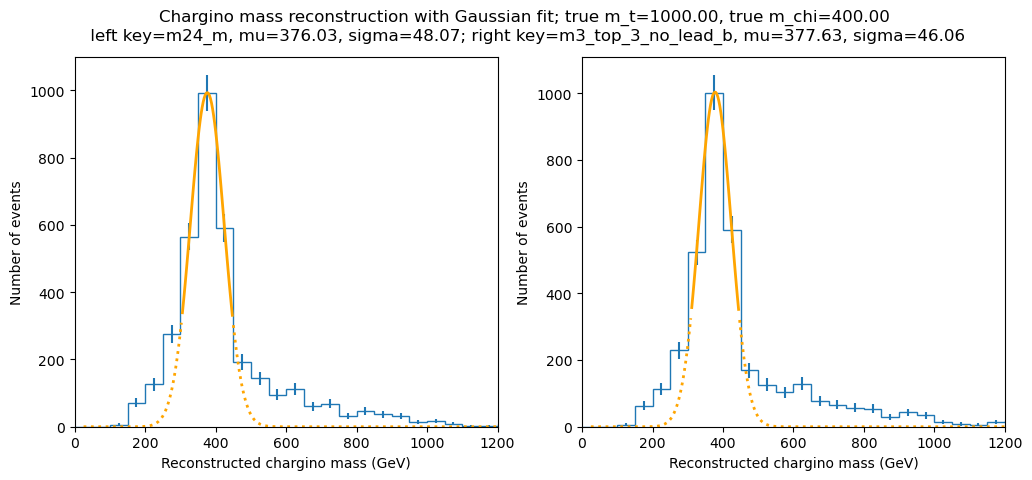

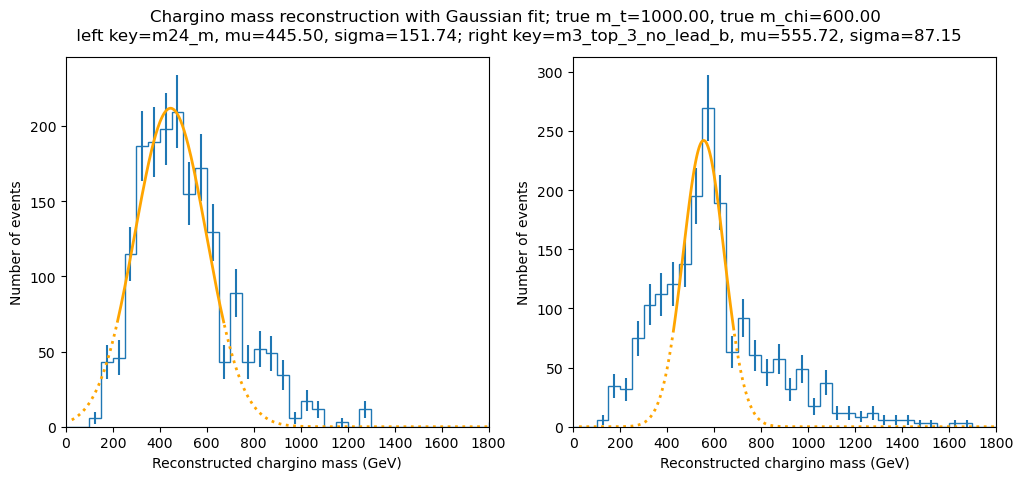

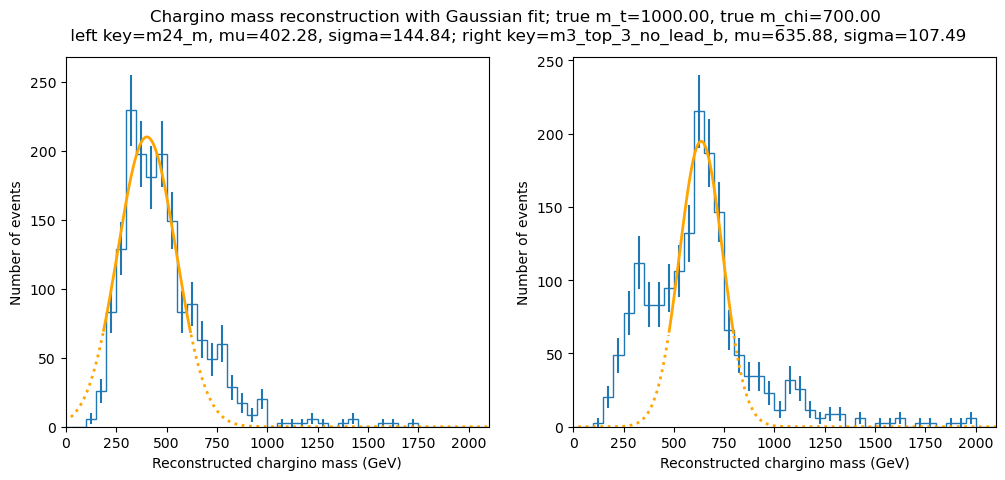

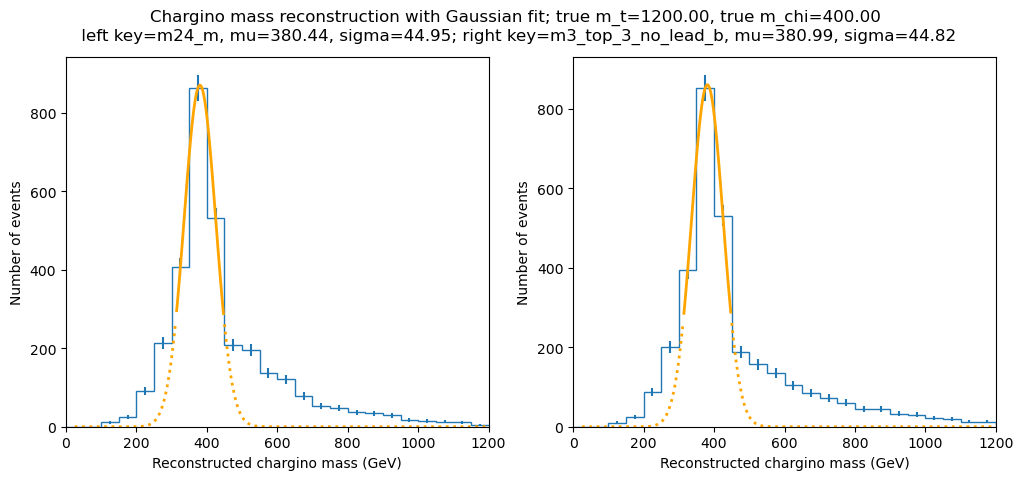

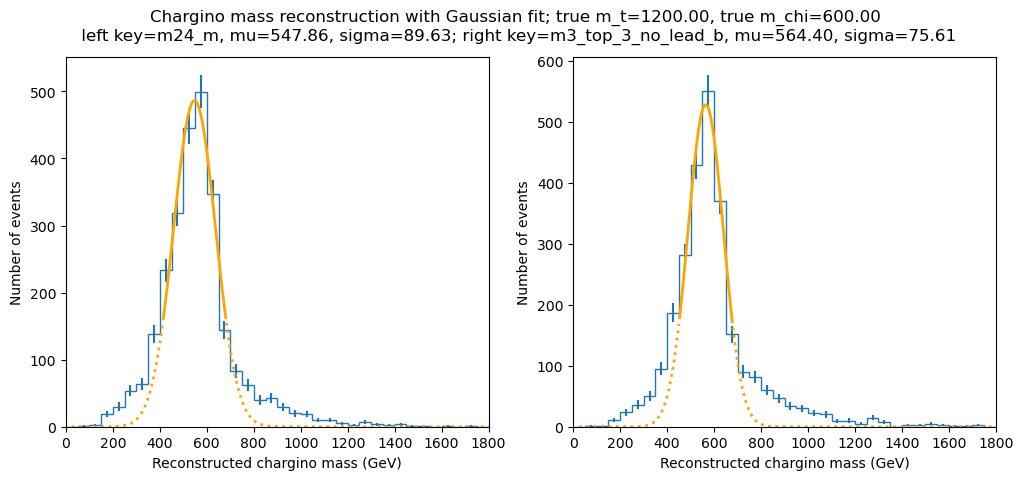

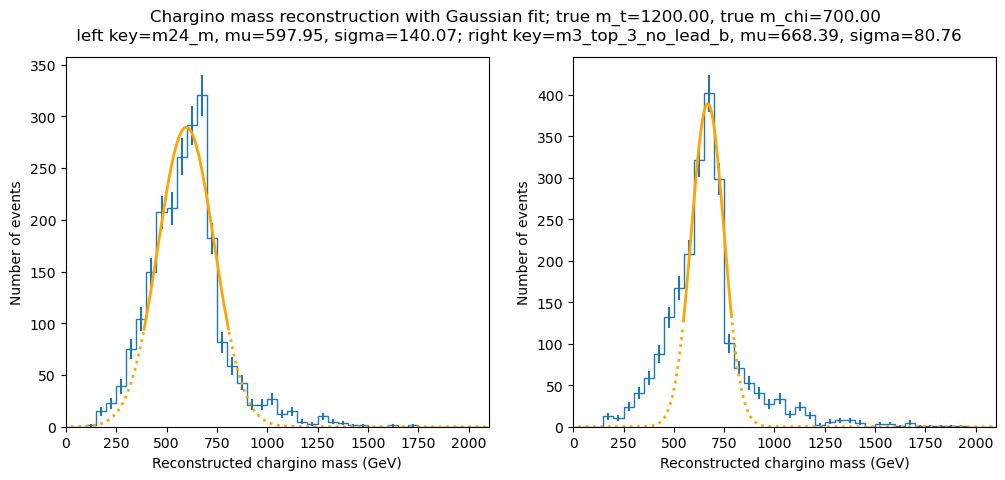

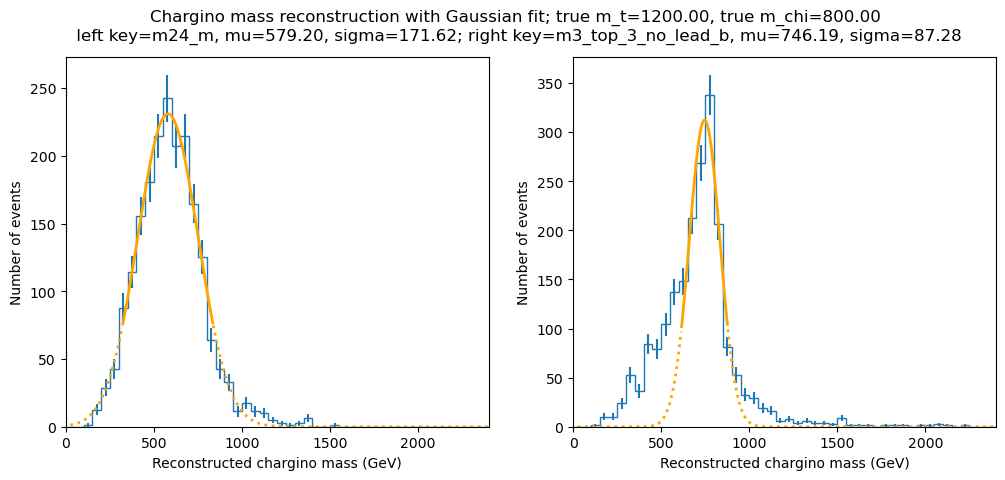

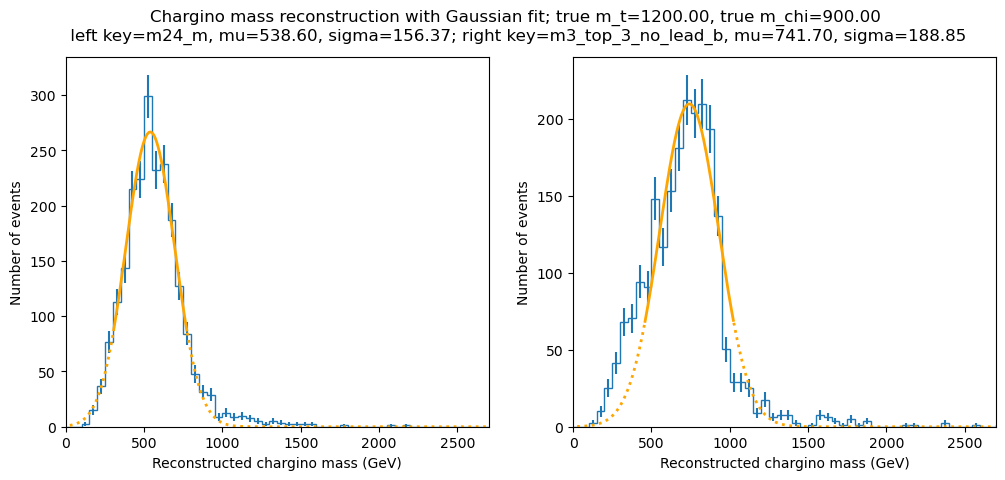

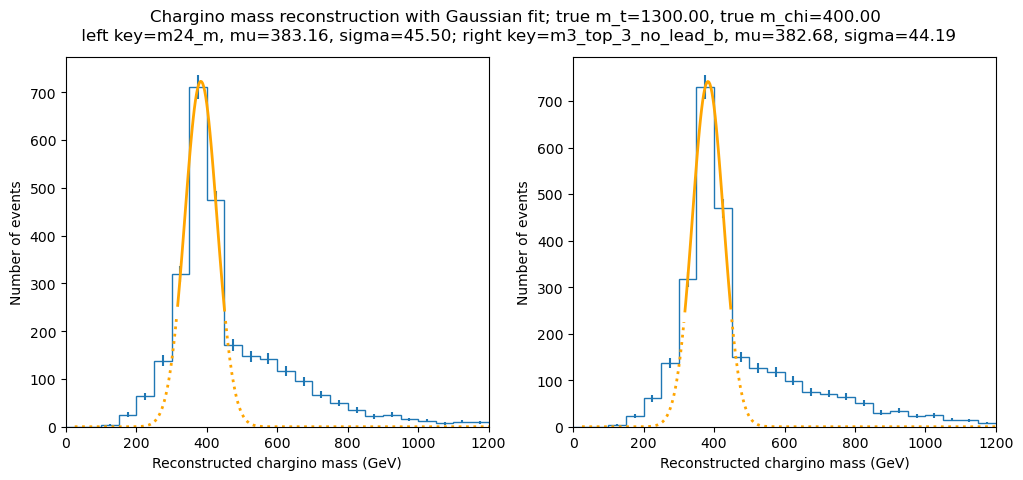

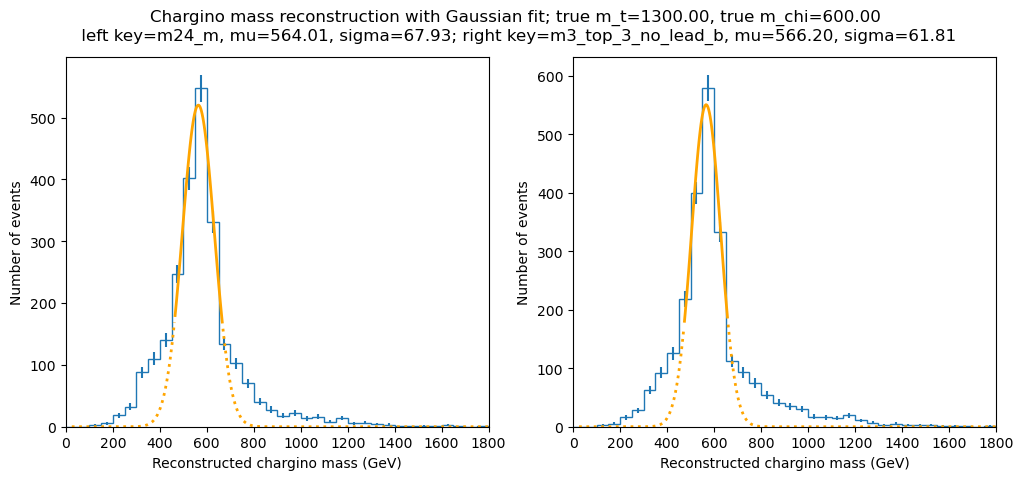

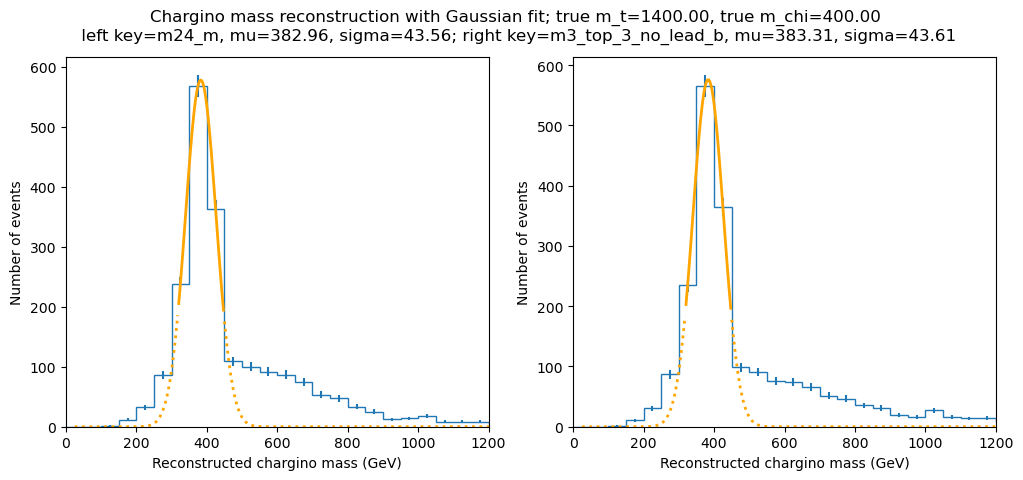

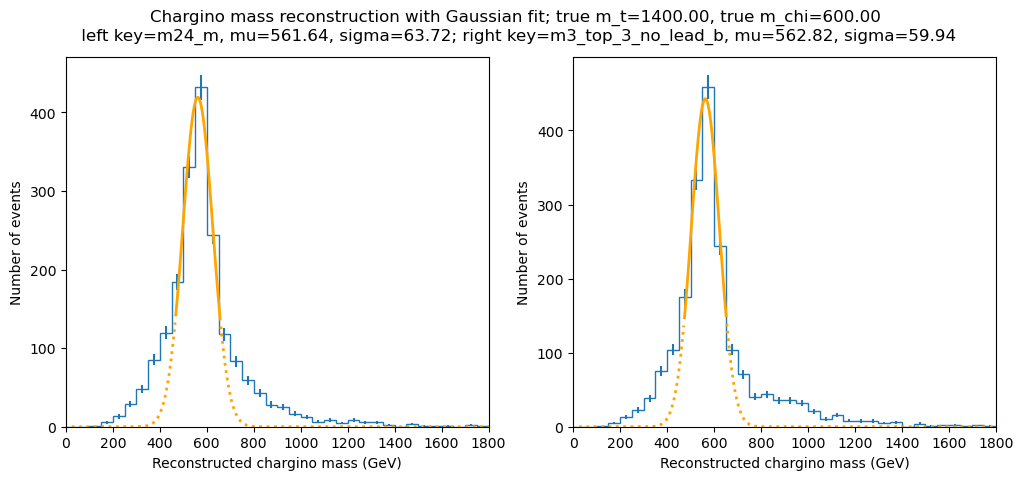

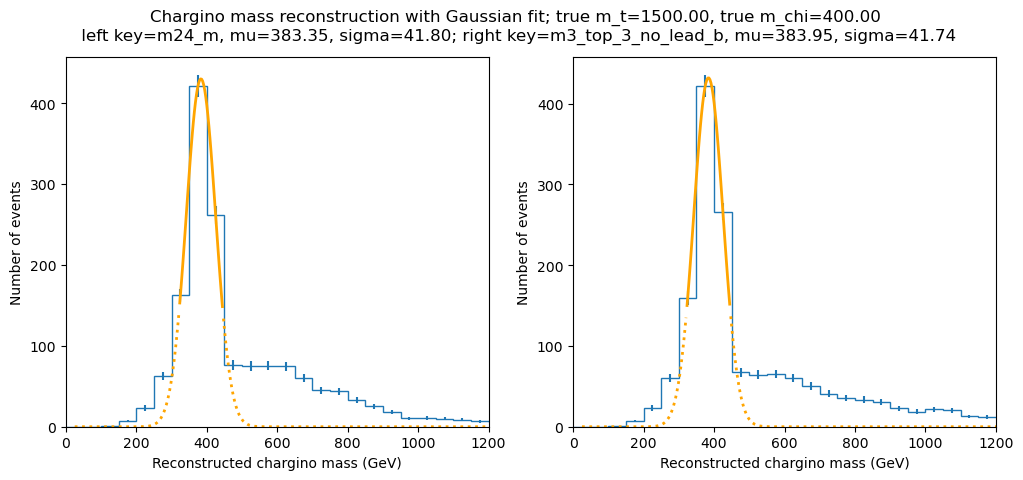

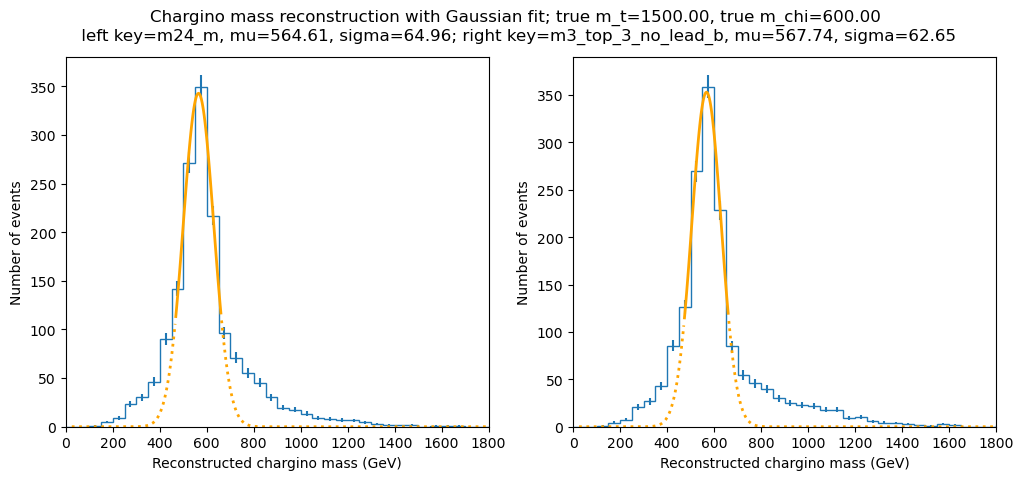

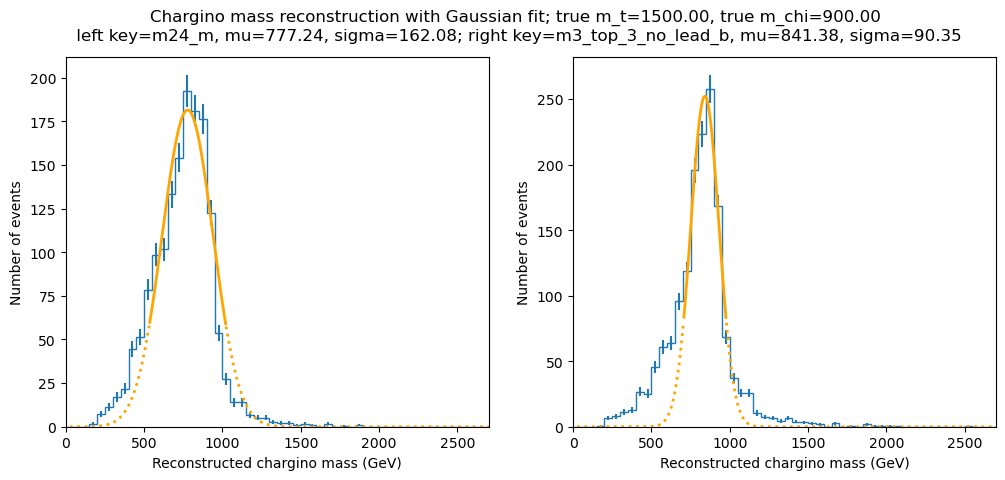

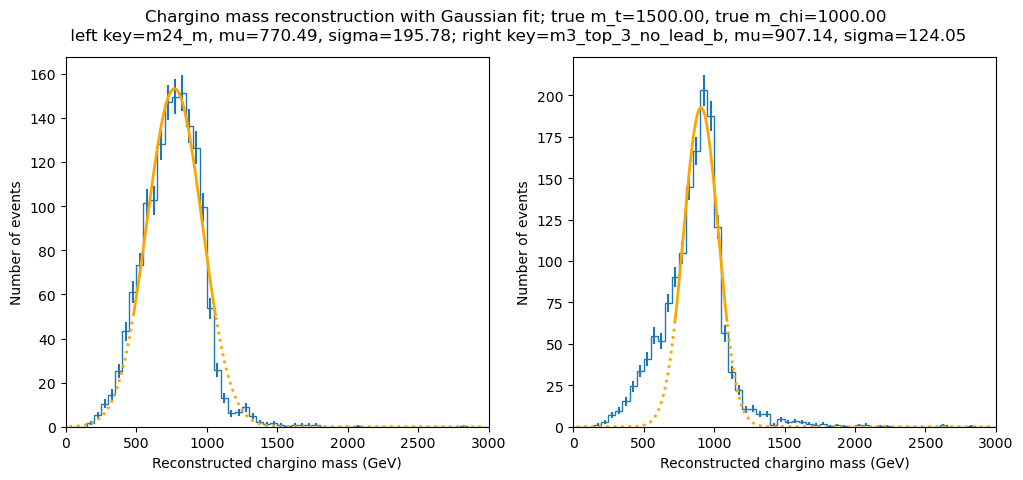

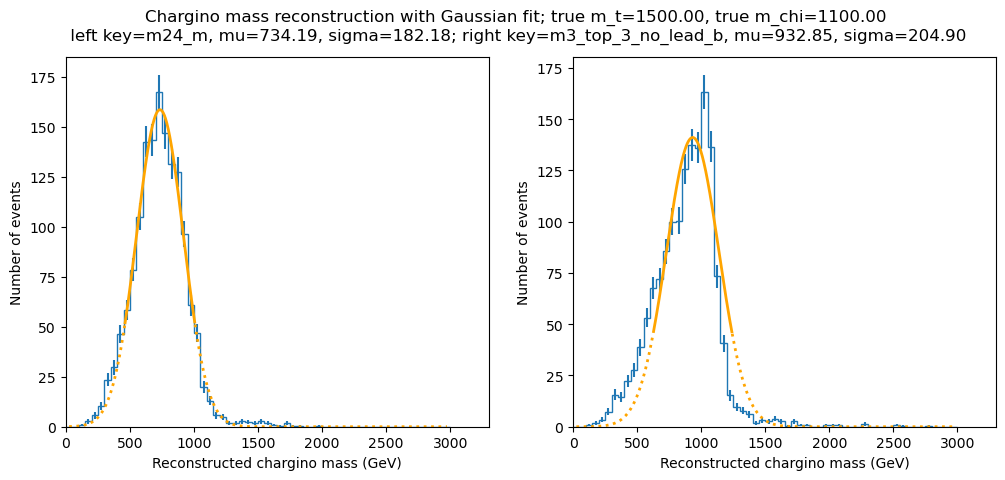

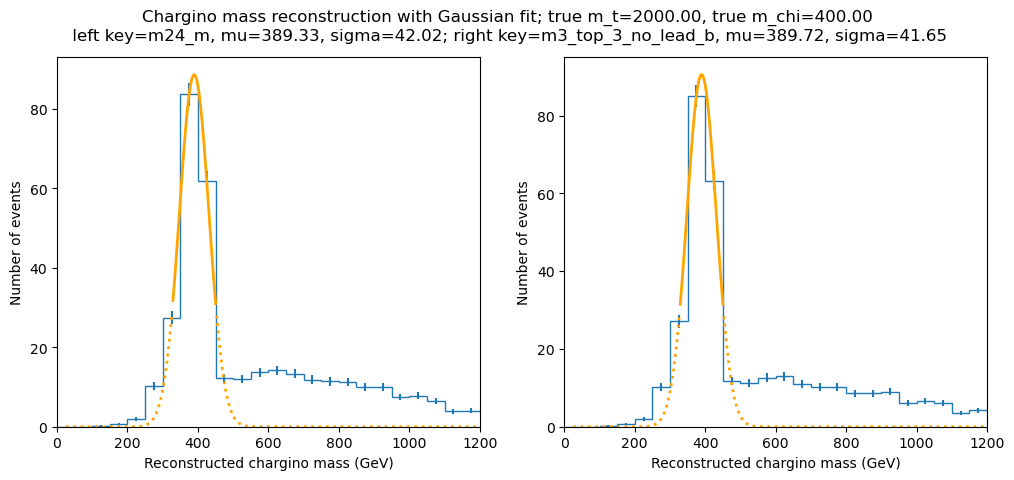

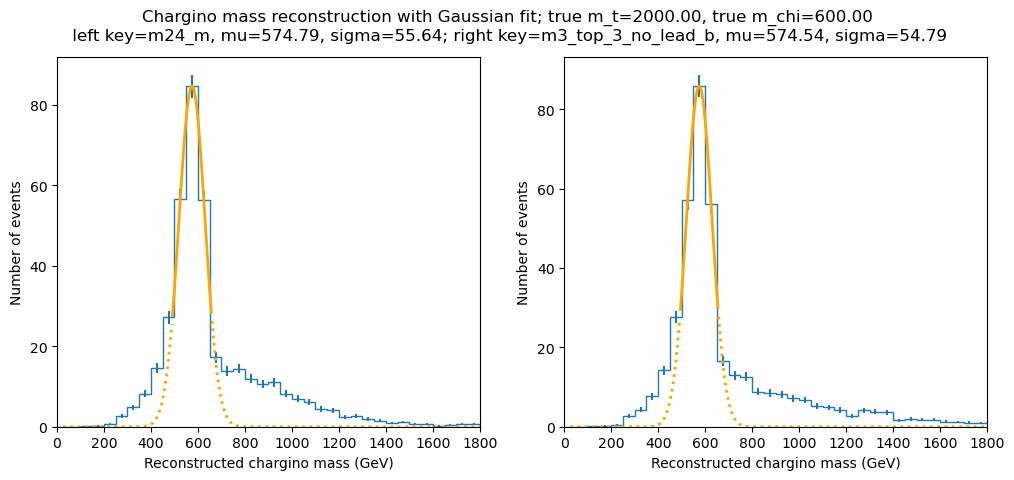

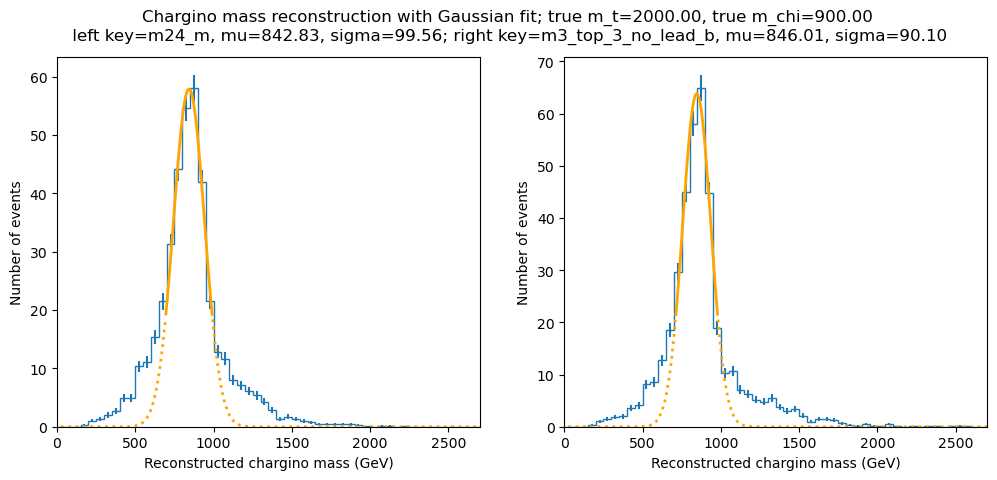

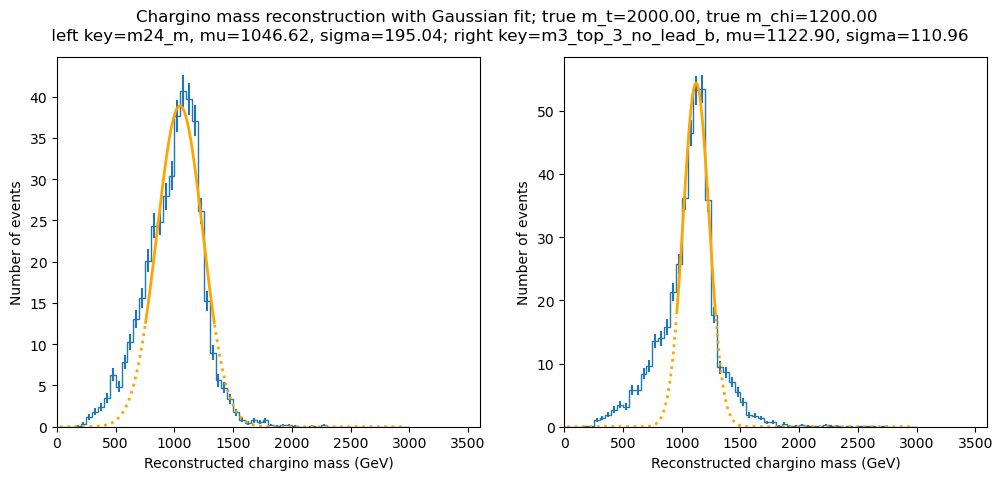

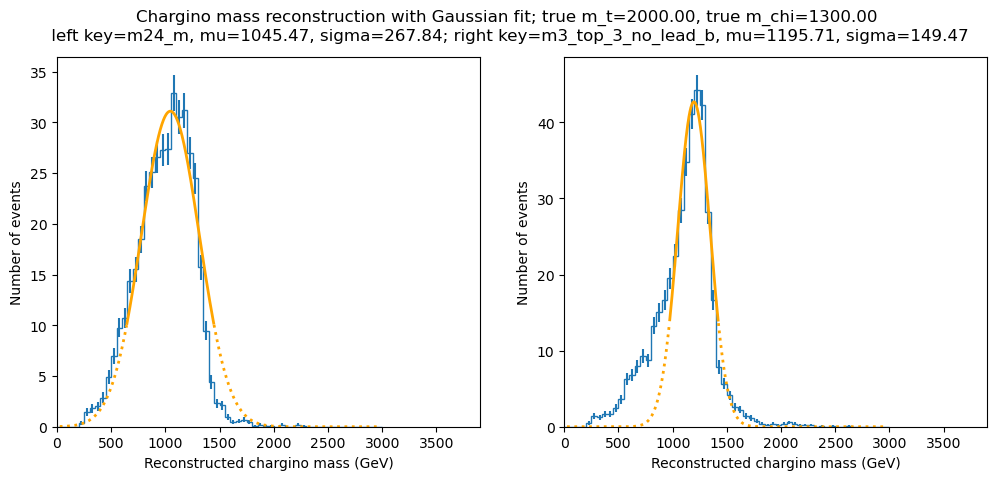

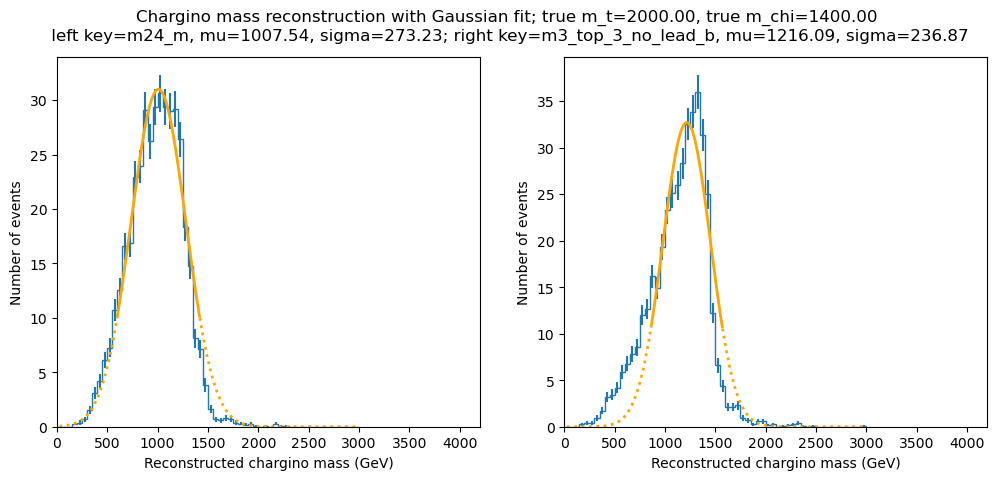

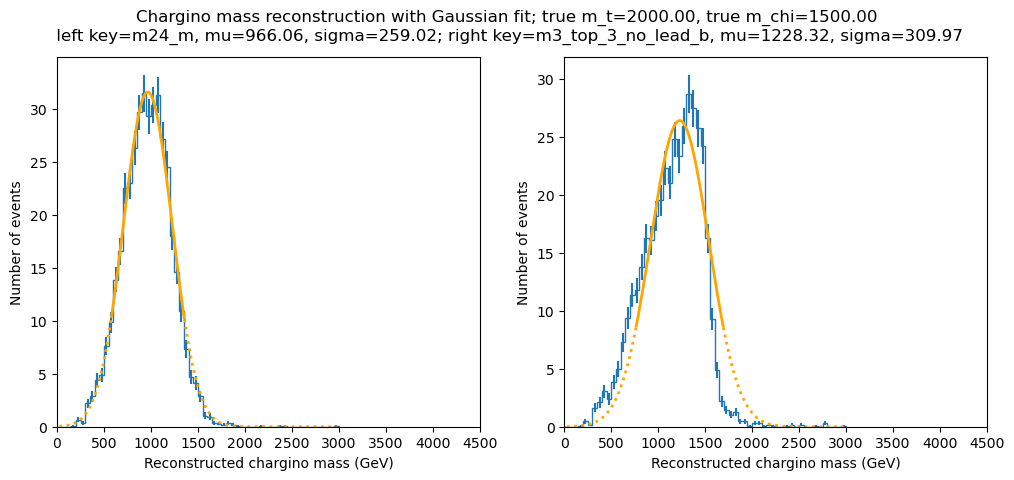

In [29]:
basic_flavor_aware_comp = gaussian_fit_performance_comparison("m24_m", "m3_top_3_no_lead_b", -0.75, create_plots=True)

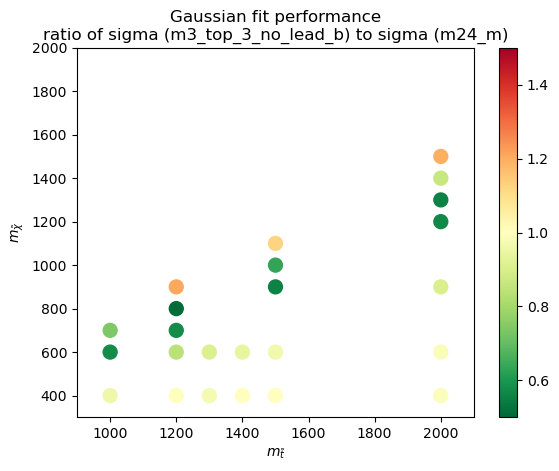

In [30]:
plot_gaussian_perf_comp("m24_m", "m3_top_3_no_lead_b", basic_flavor_aware_comp)

### Flavor-aware algorithm with $\Delta r$ info, threshold=1.25 (`m3_top_3_no_lead_b_delta_r_cut`)

/tmp/ipykernel_337525/2505557922.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  coeff, _ = curve_fit(gaussian, masked_bin_ctrs, masked_data, p0=coeff)
/tmp/ipykernel_337525/2505557922.py:43: UserWarning: Iterative Gaussian fit never converged. The algorithm may be oscillating between two fits that are not within the tolerance.
  warnings.warn(f"Iterative Gaussian fit never converged. The algorithm may be oscillating between two fits that are not within the tolerance.")
/tmp/ipykernel_337525/1389735743.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2)


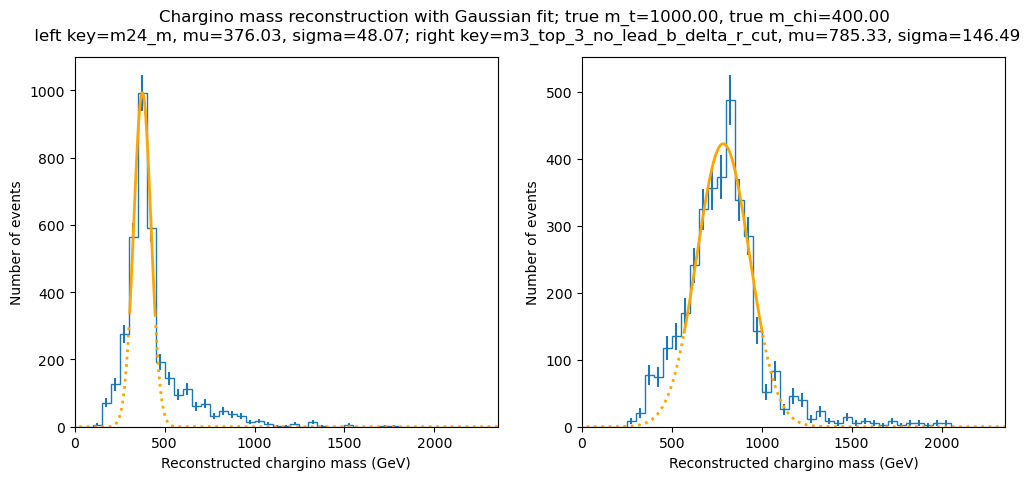

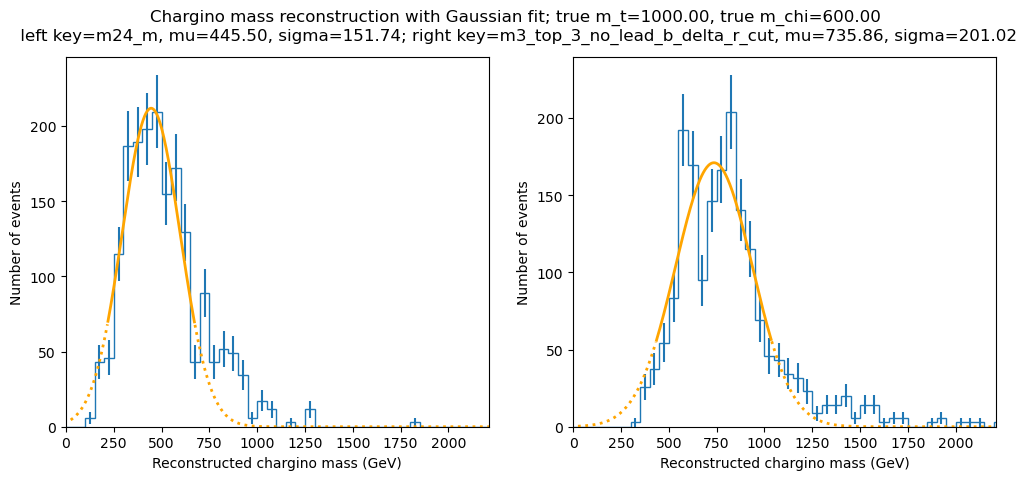

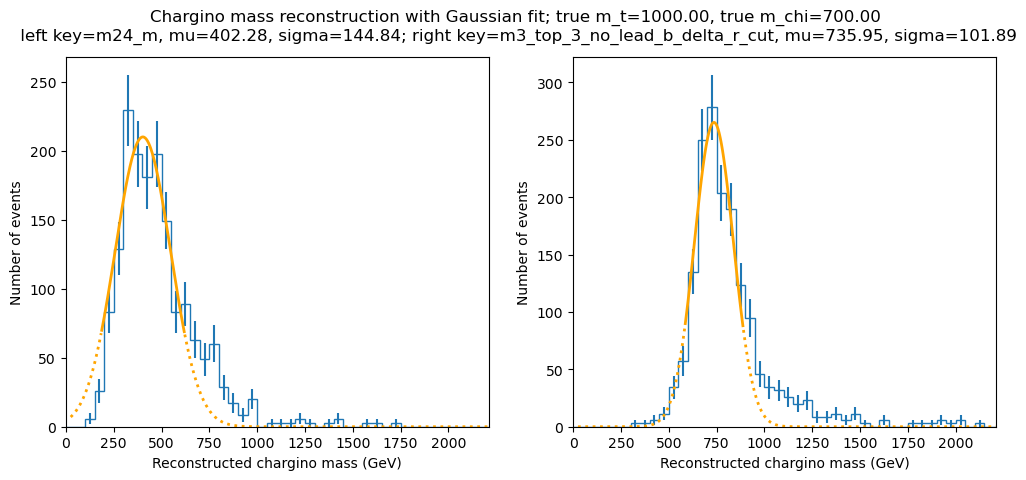

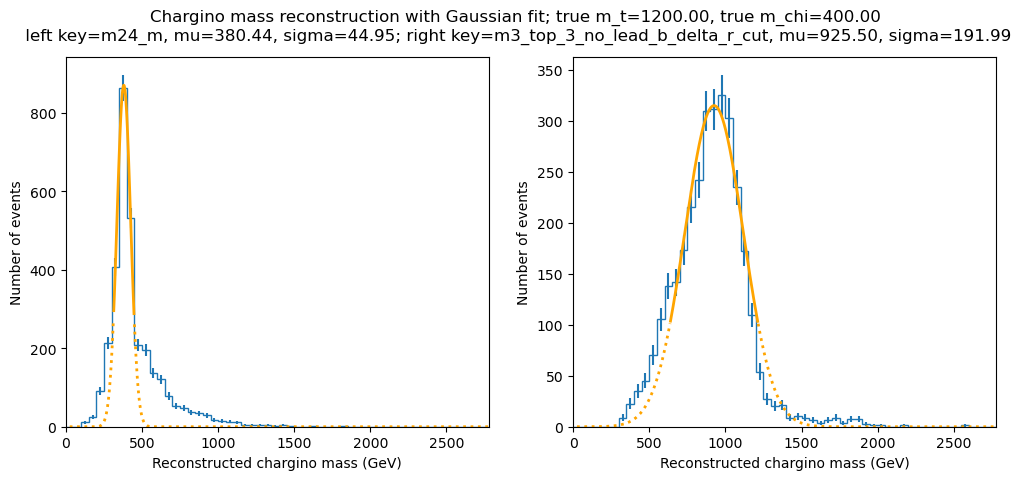

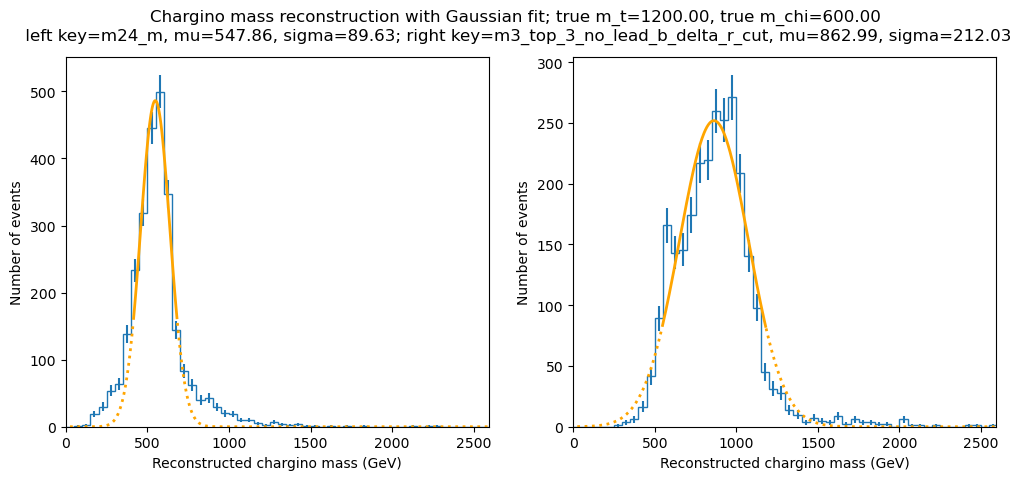

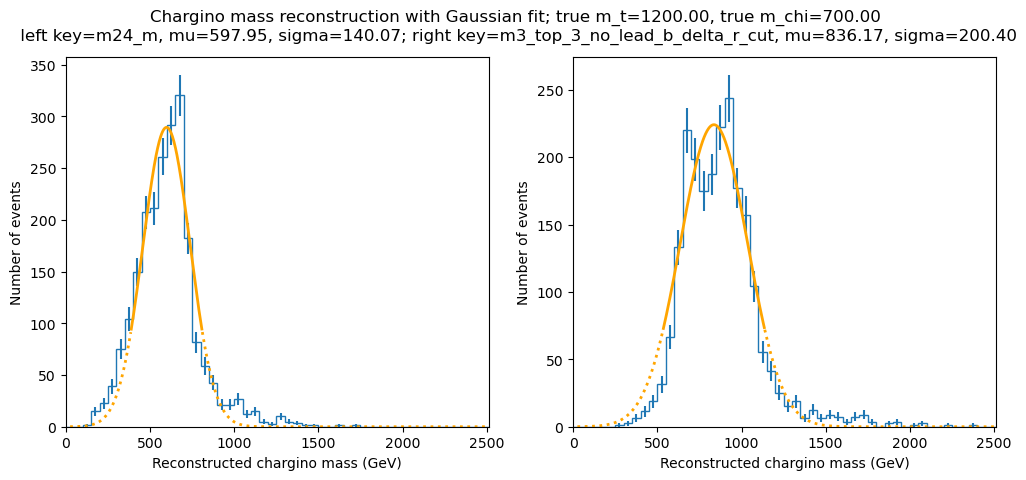

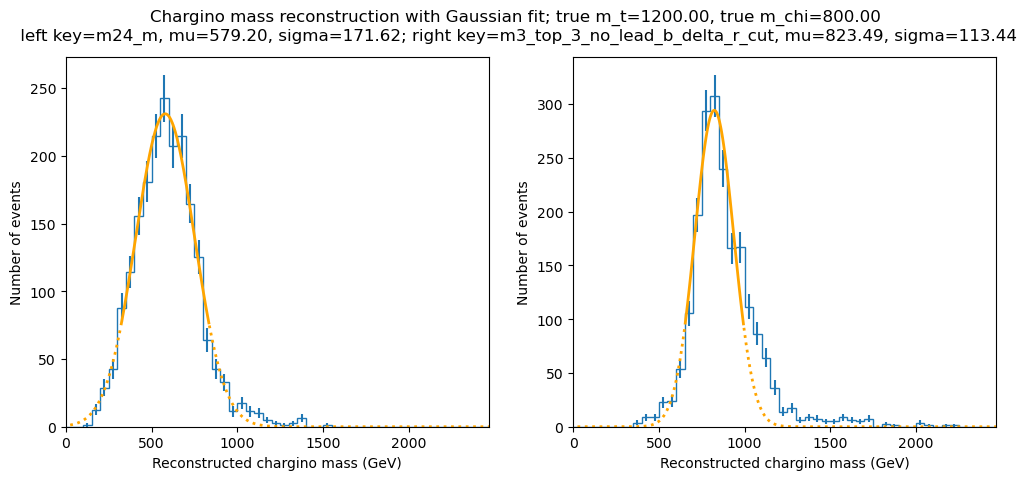

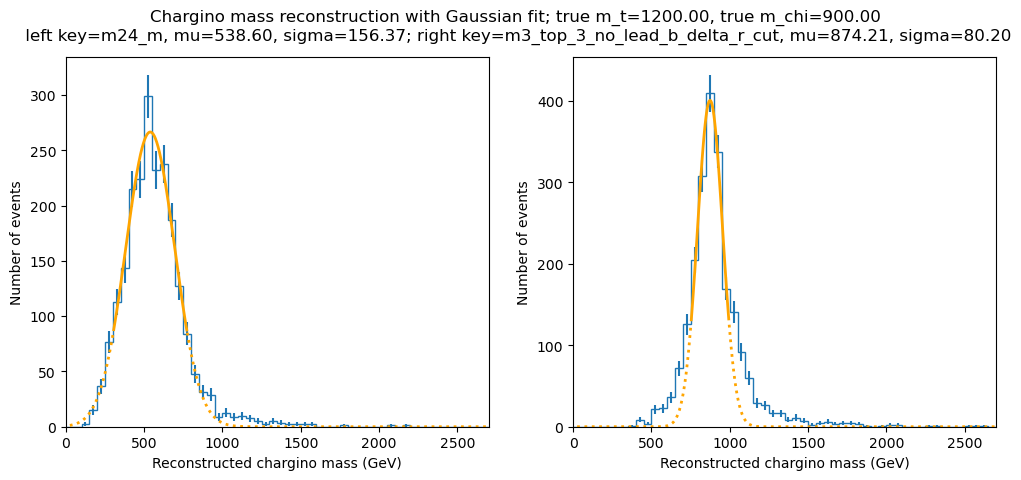

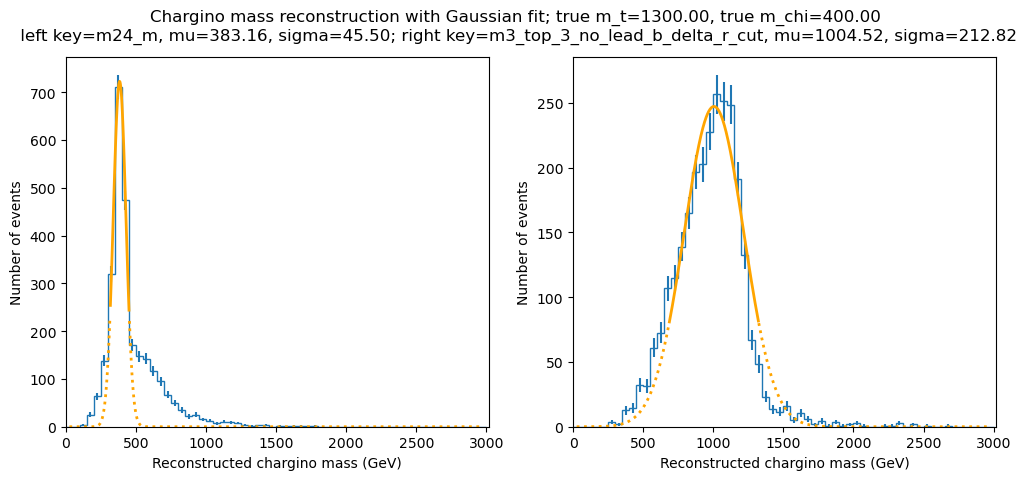

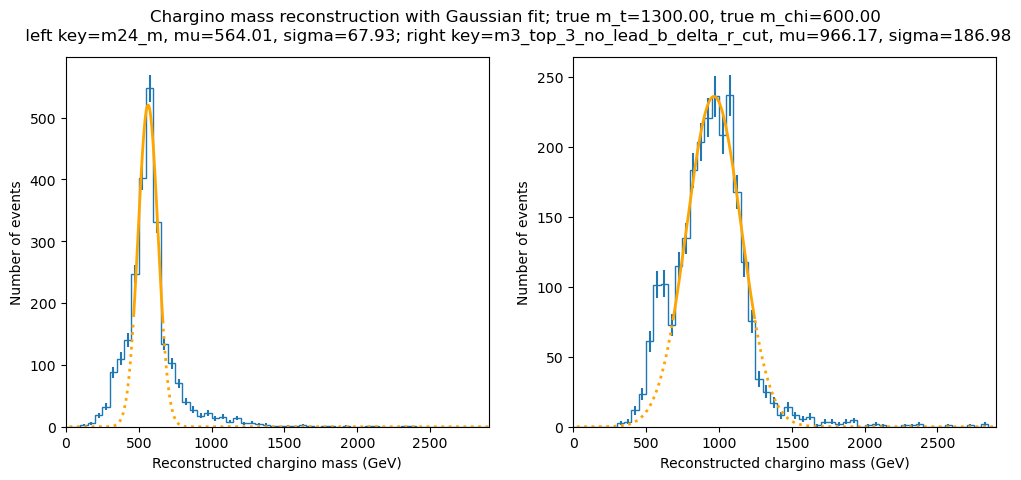

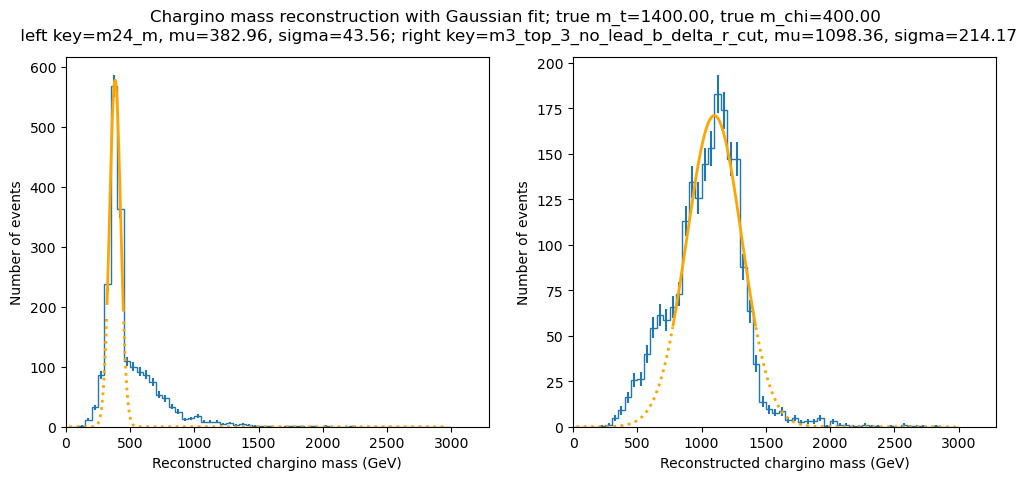

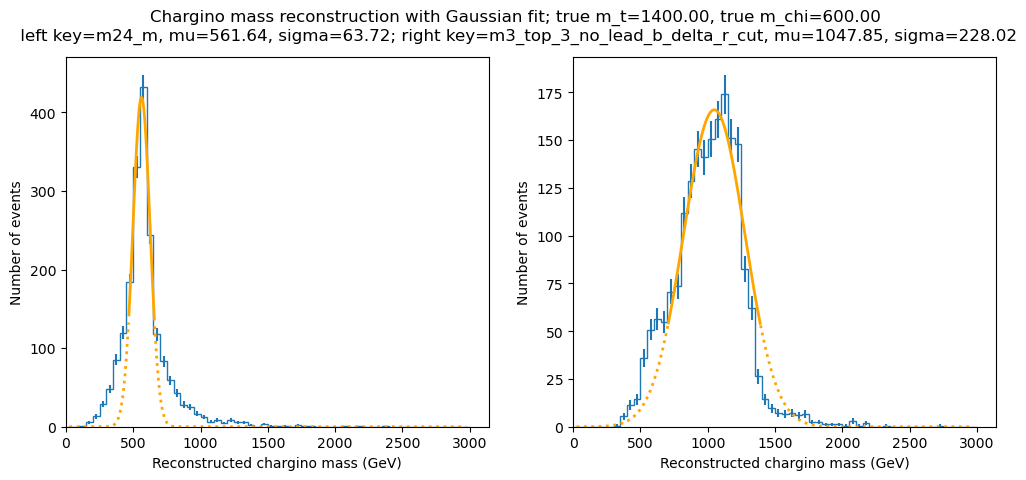

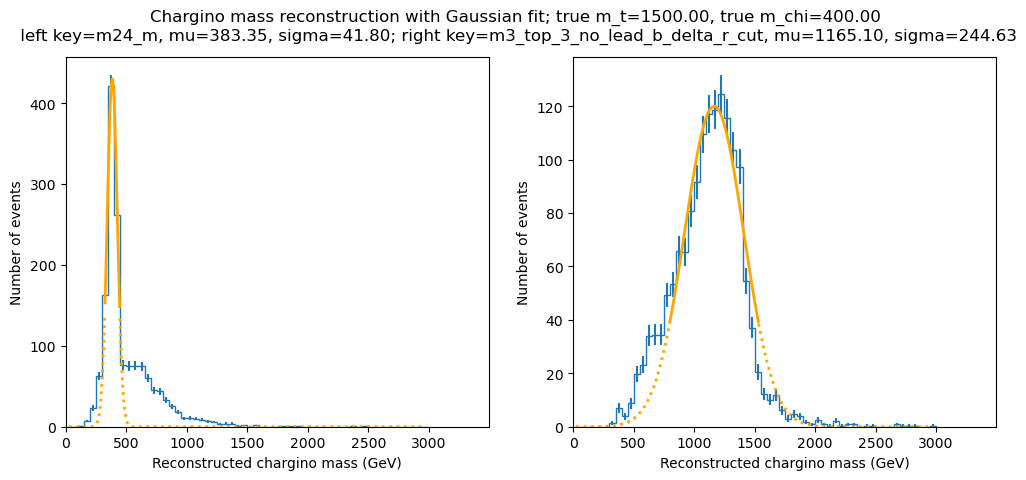

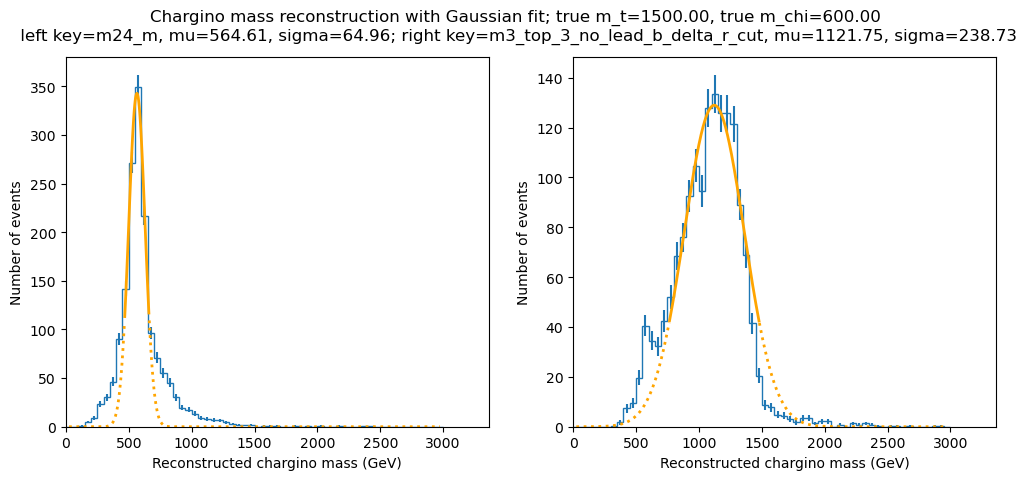

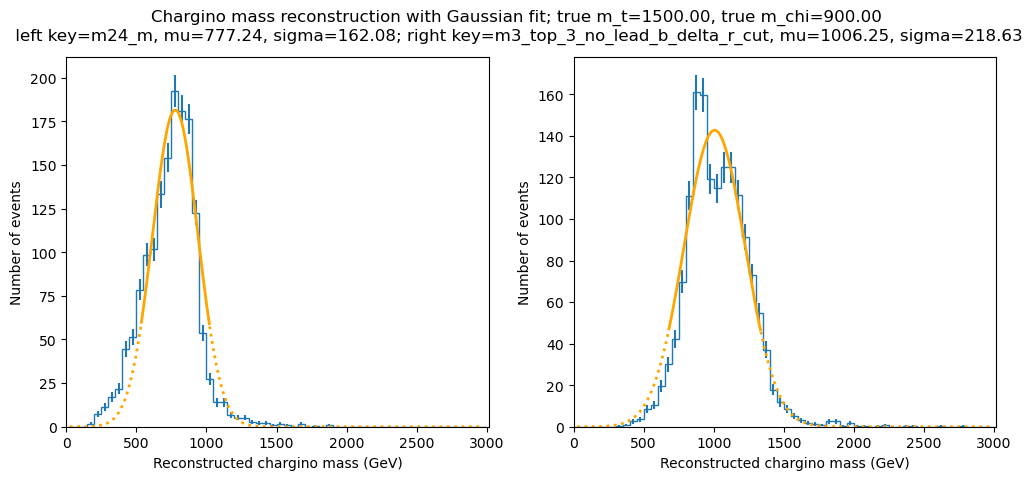

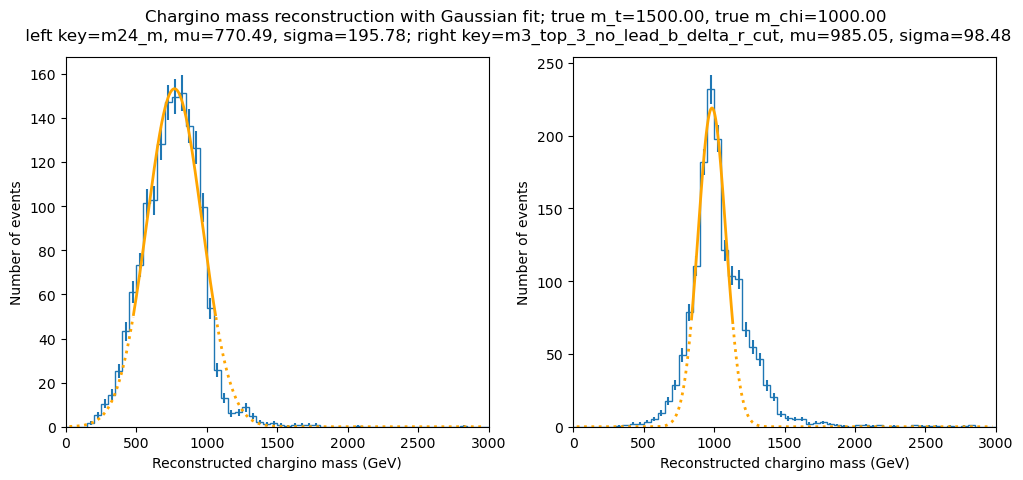

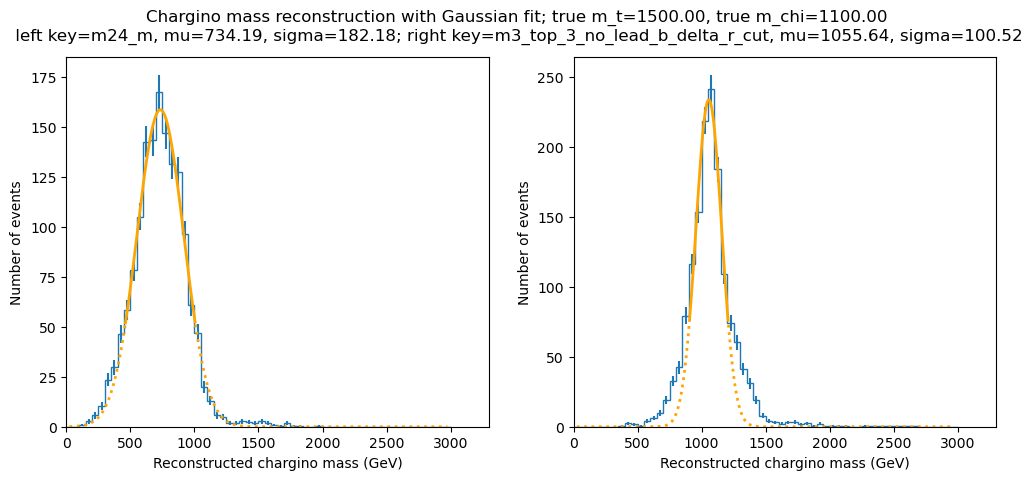

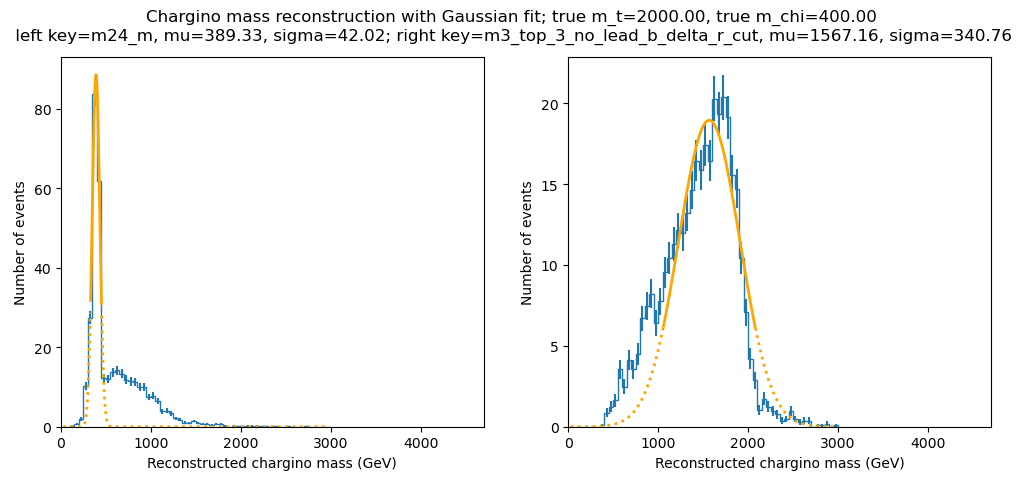

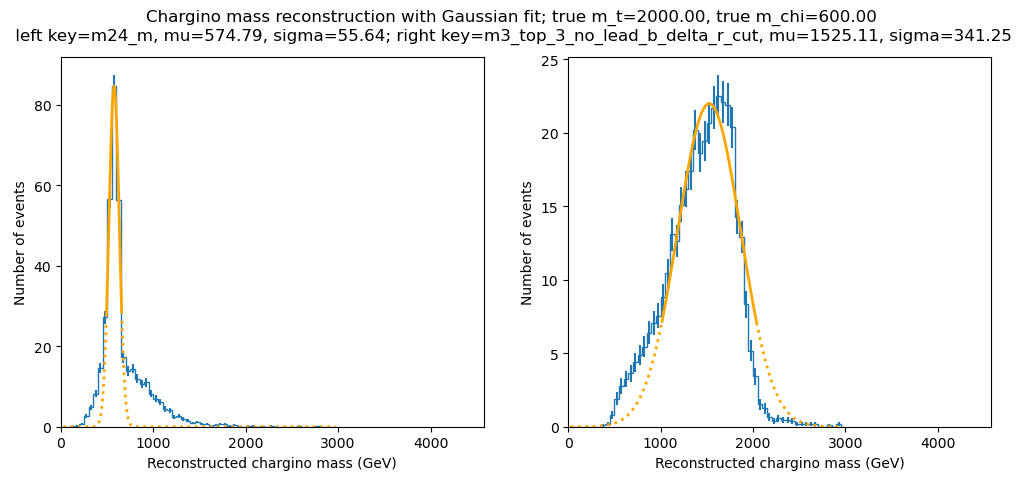

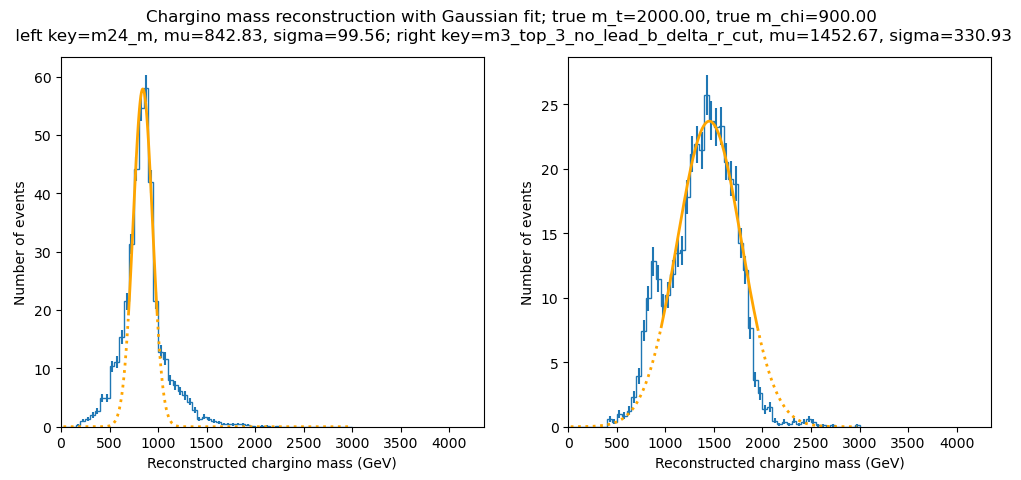

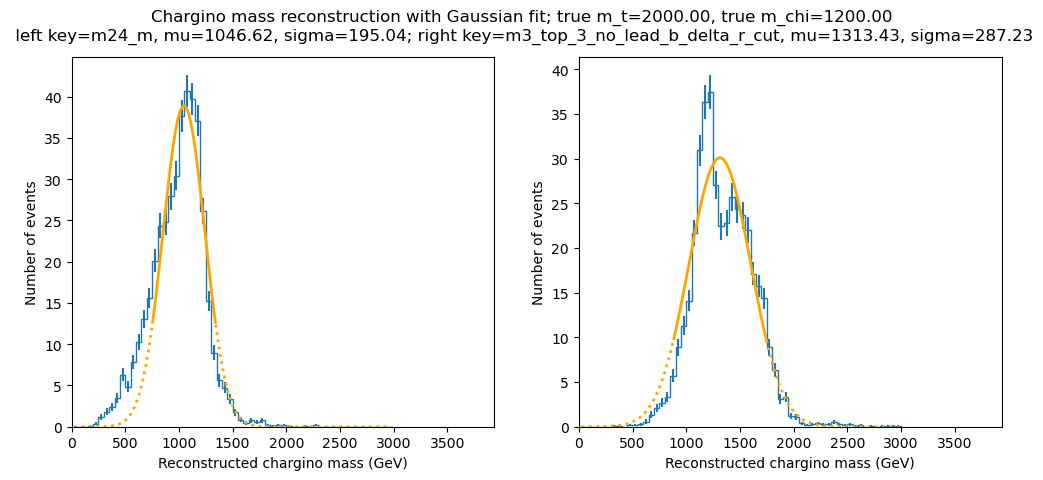

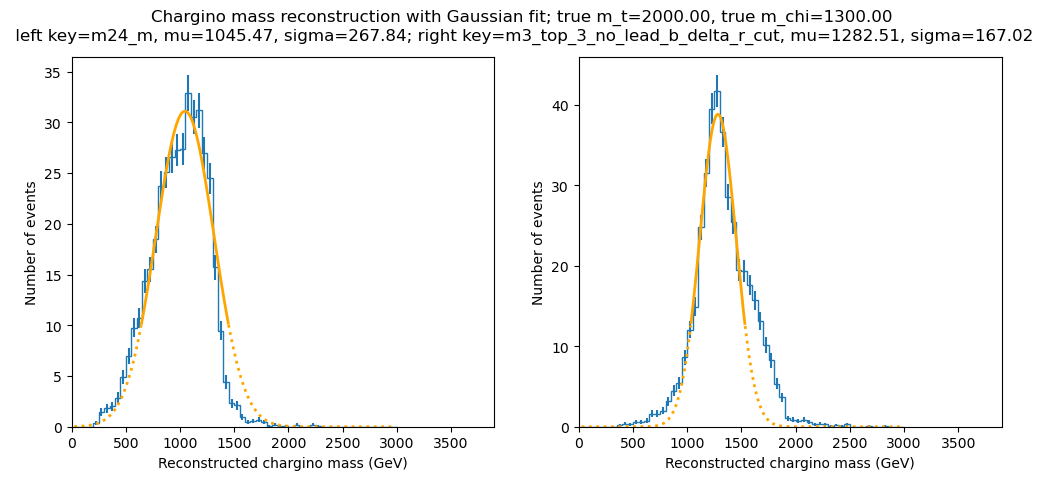

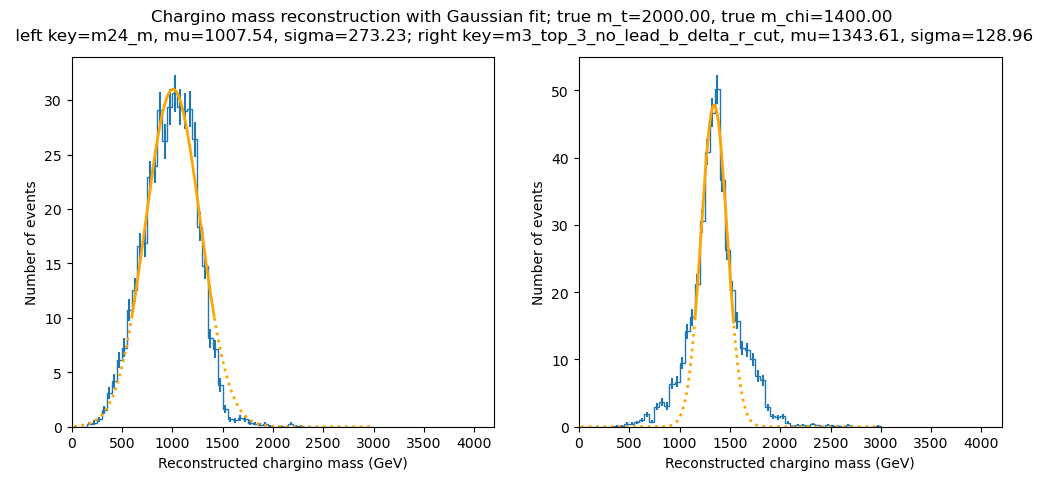

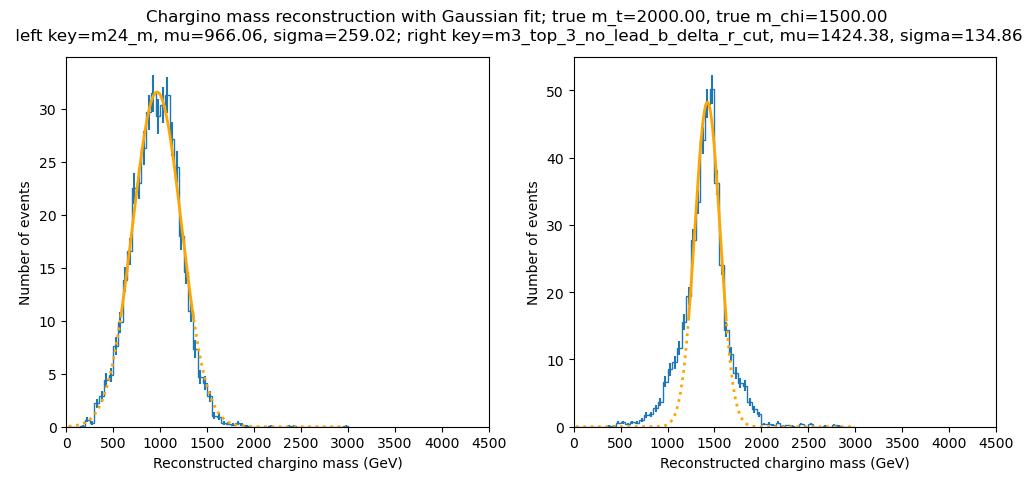

In [31]:
deltar_inc_flavor_aware_comp = gaussian_fit_performance_comparison("m24_m", "m3_top_3_no_lead_b_delta_r_cut", -0.75, create_plots=True) 

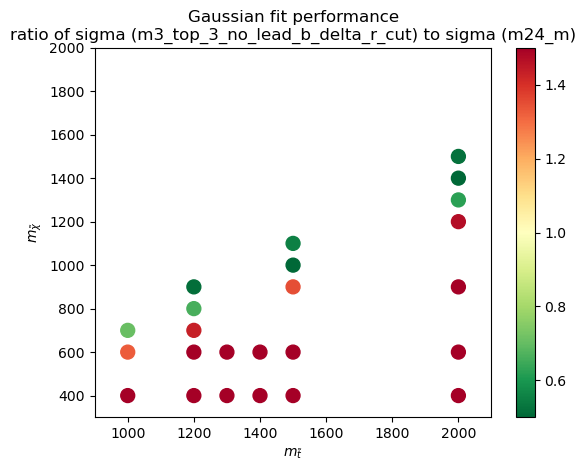

In [32]:
plot_gaussian_perf_comp("m24_m", "m3_top_3_no_lead_b_delta_r_cut", deltar_inc_flavor_aware_comp)

### Musical ~~chairs~~ jets, threshold=1.25 (`m3_234_235_236_delta_r_cut`)

/tmp/ipykernel_337525/2505557922.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  coeff, _ = curve_fit(gaussian, masked_bin_ctrs, masked_data, p0=coeff)
/tmp/ipykernel_337525/2505557922.py:43: UserWarning: Iterative Gaussian fit never converged. The algorithm may be oscillating between two fits that are not within the tolerance.
  warnings.warn(f"Iterative Gaussian fit never converged. The algorithm may be oscillating between two fits that are not within the tolerance.")
/tmp/ipykernel_337525/1389735743.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2)


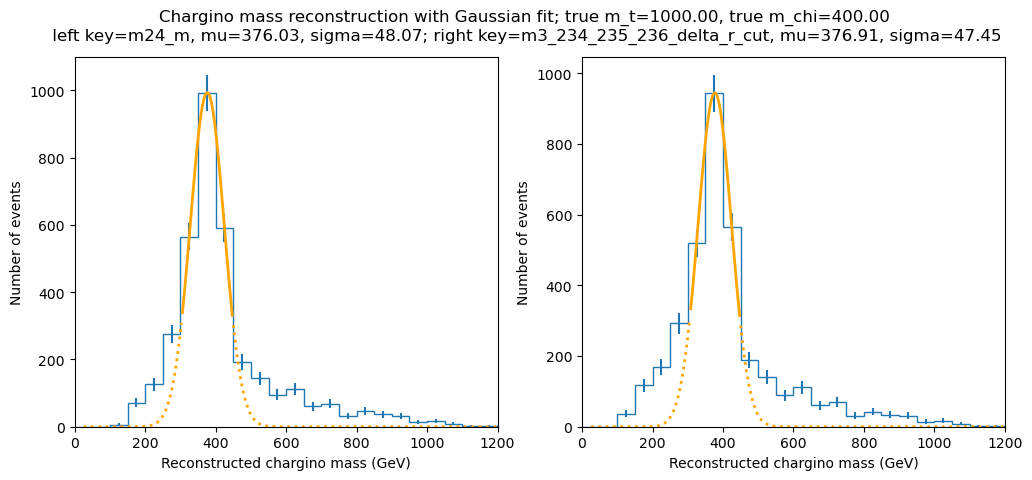

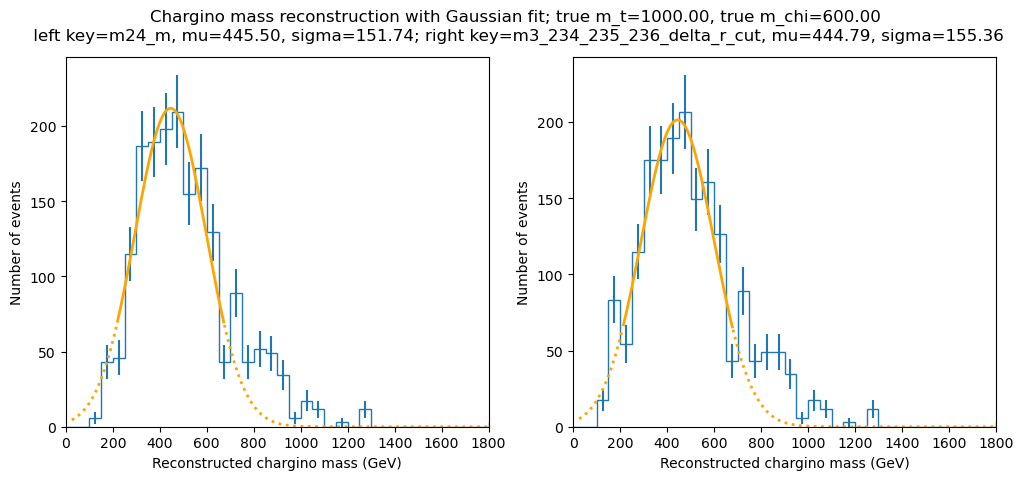

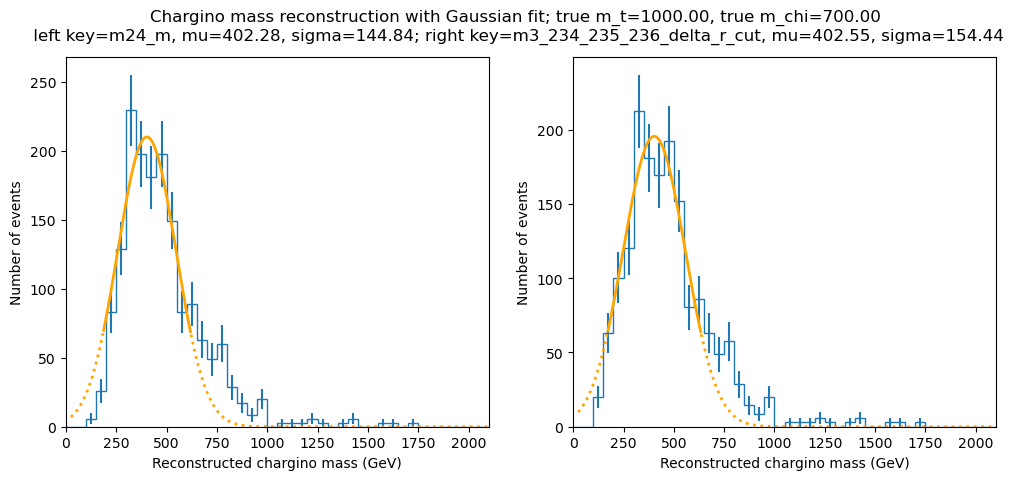

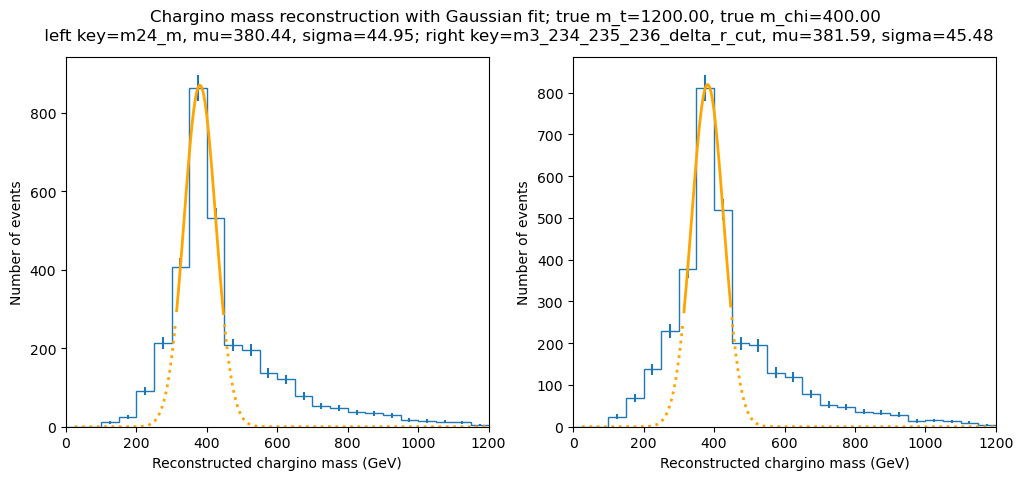

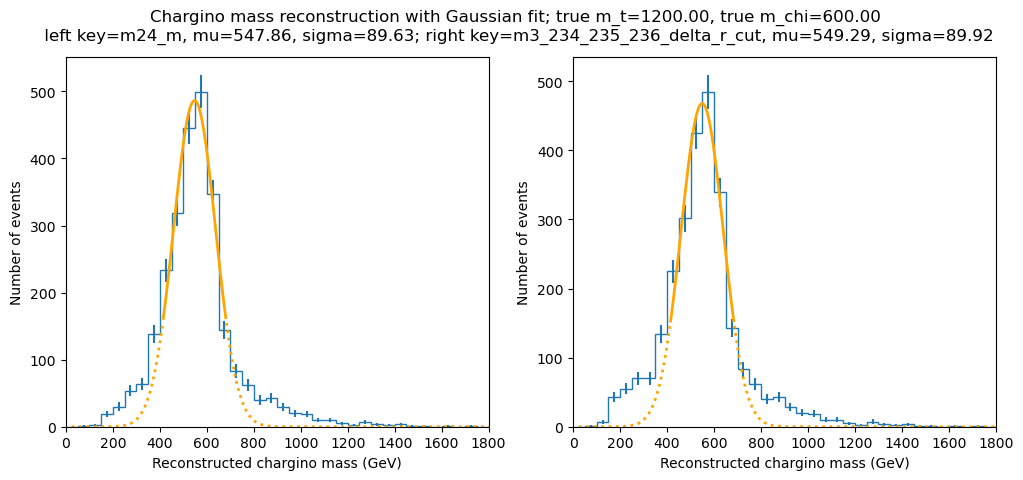

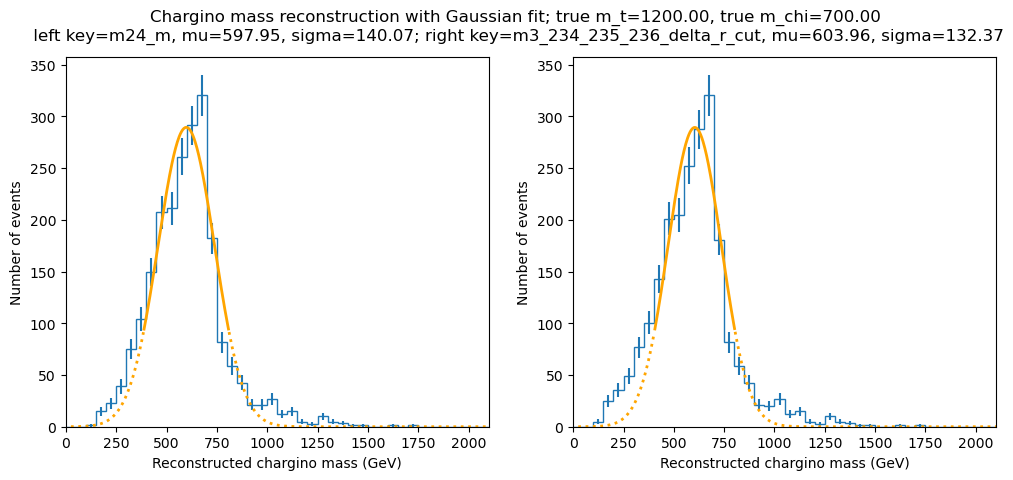

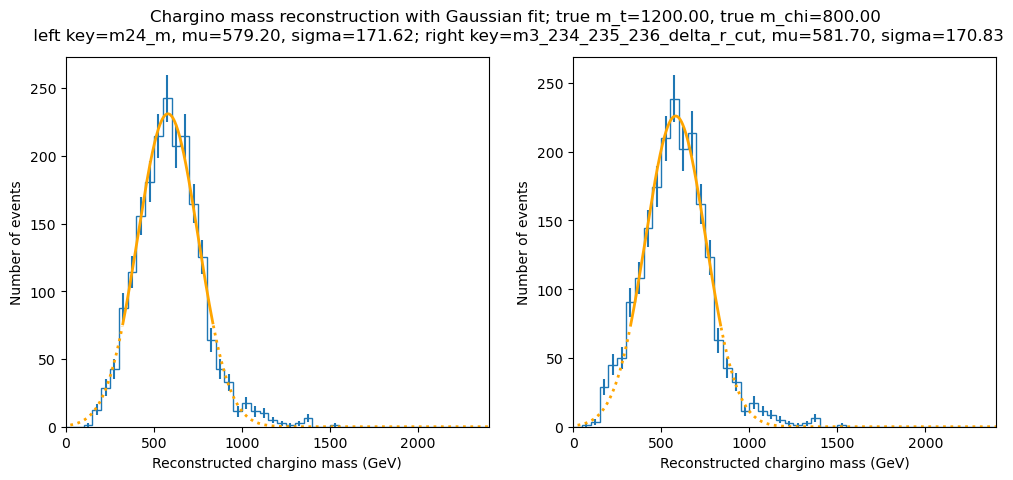

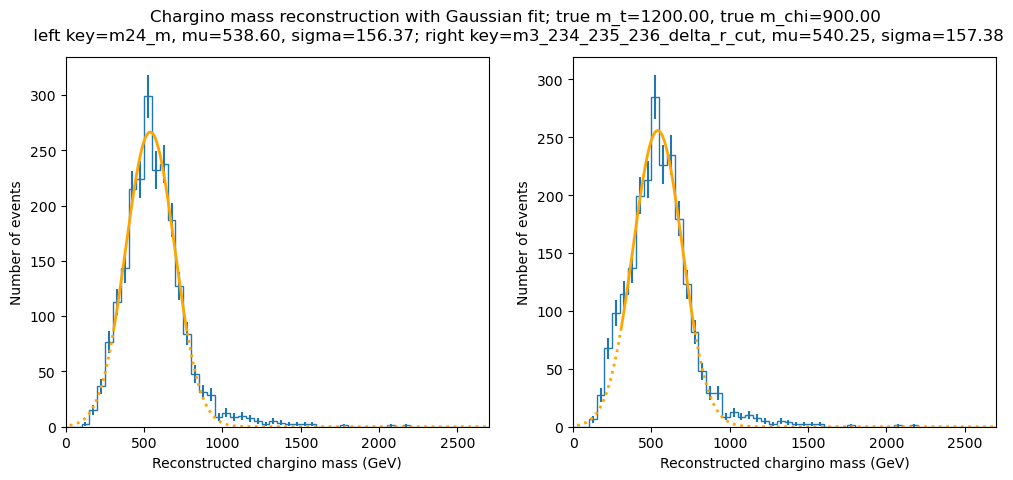

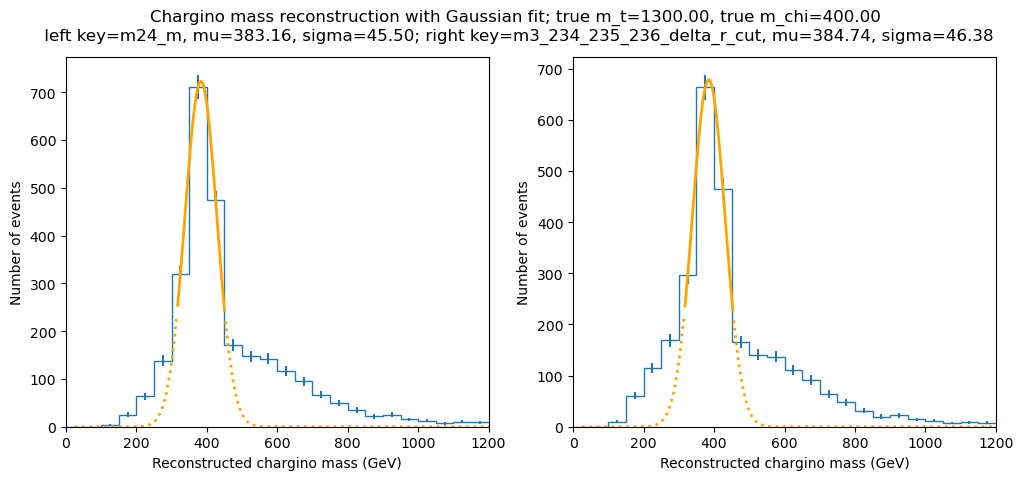

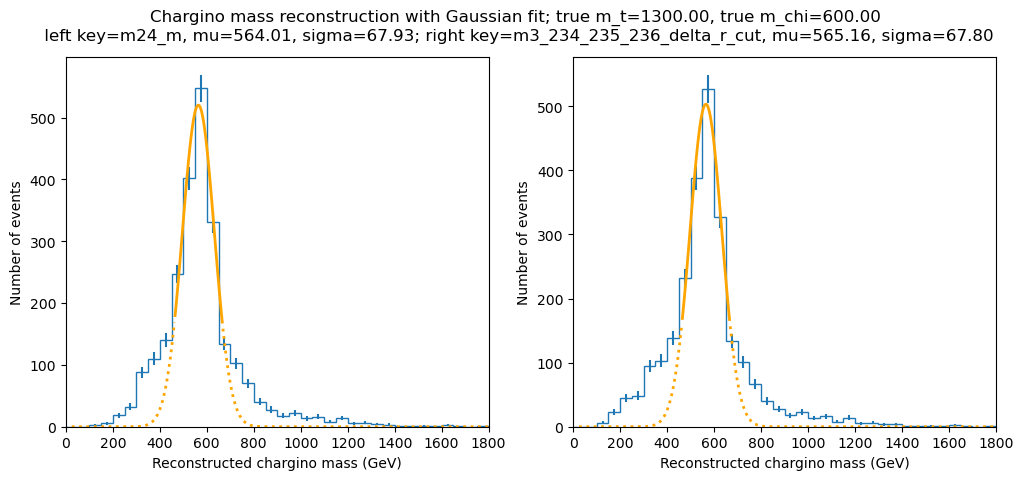

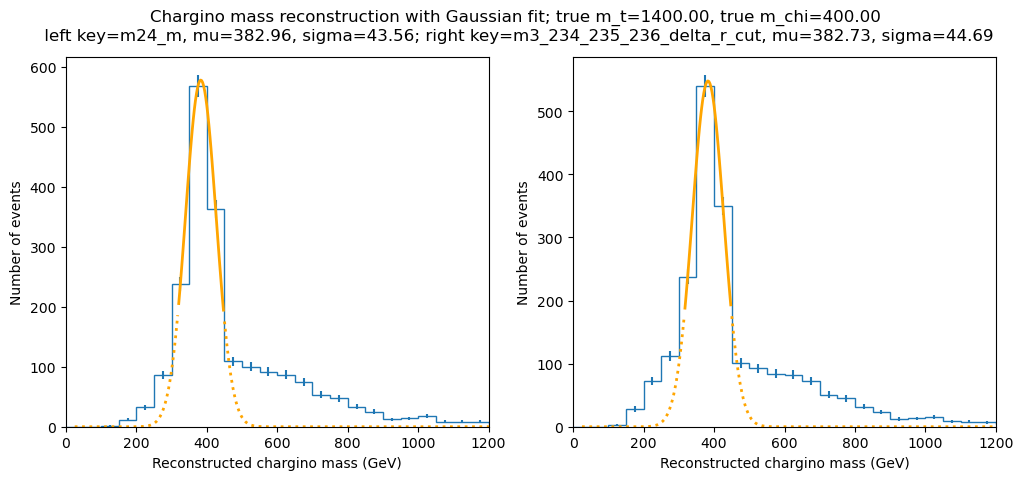

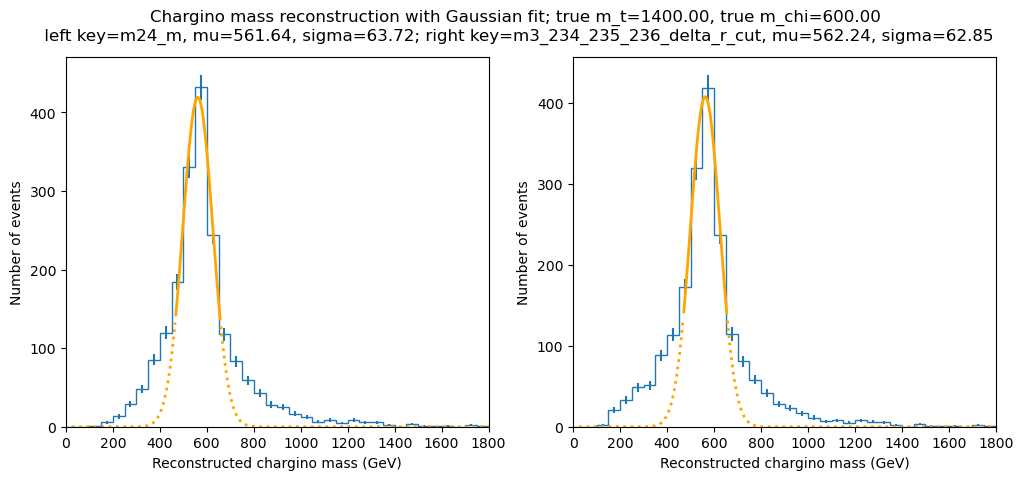

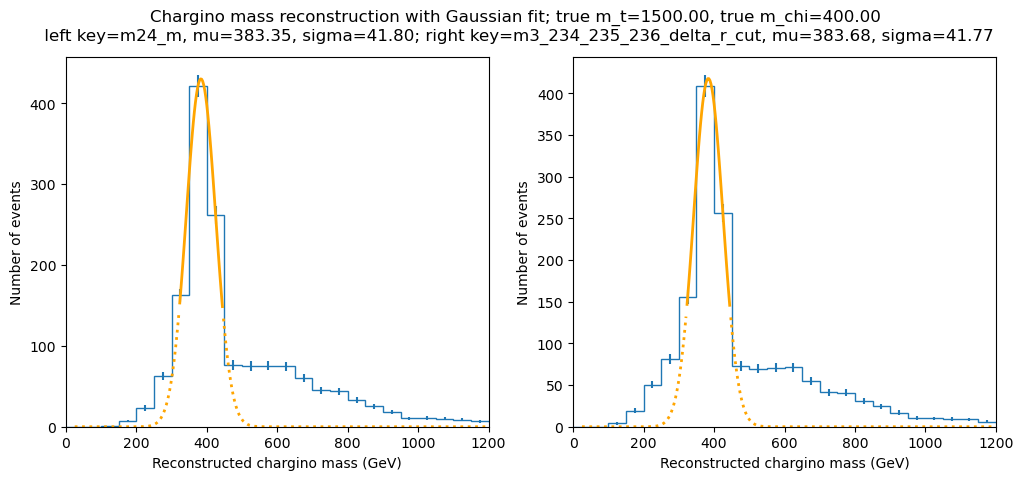

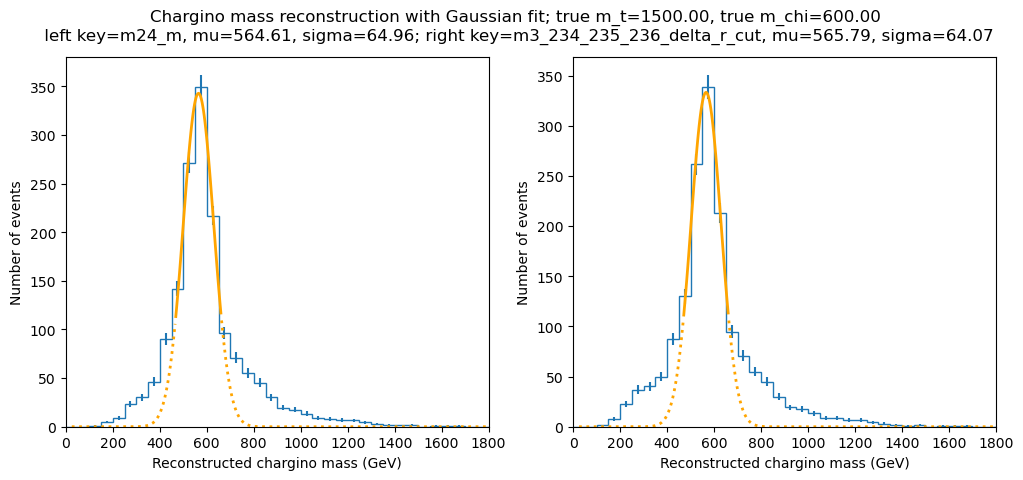

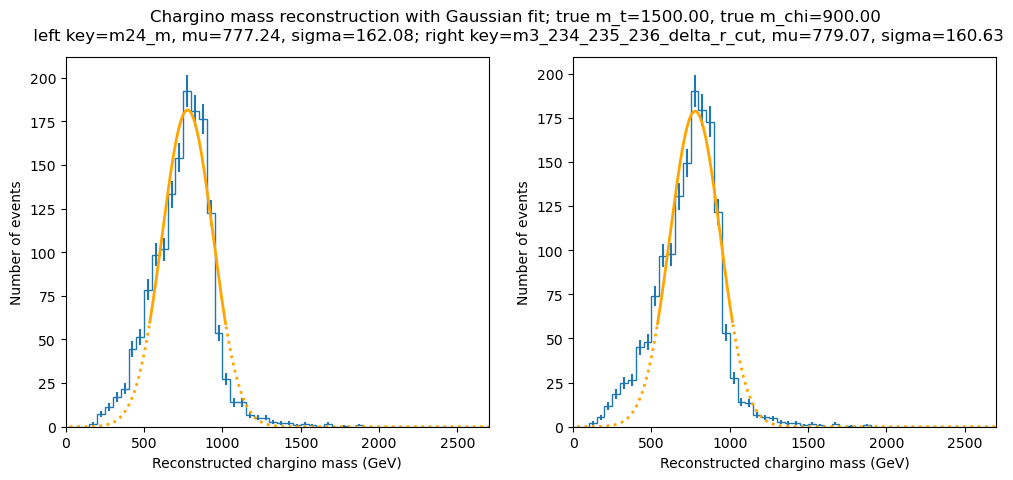

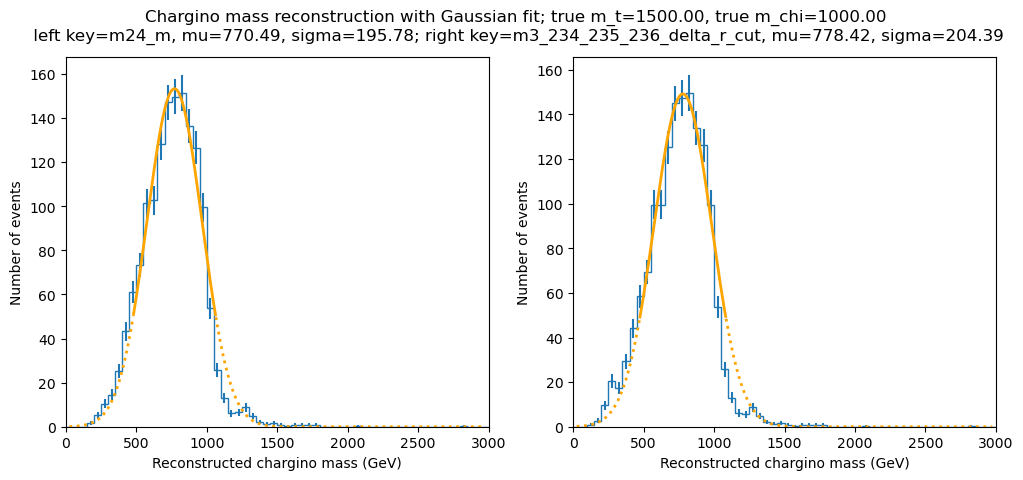

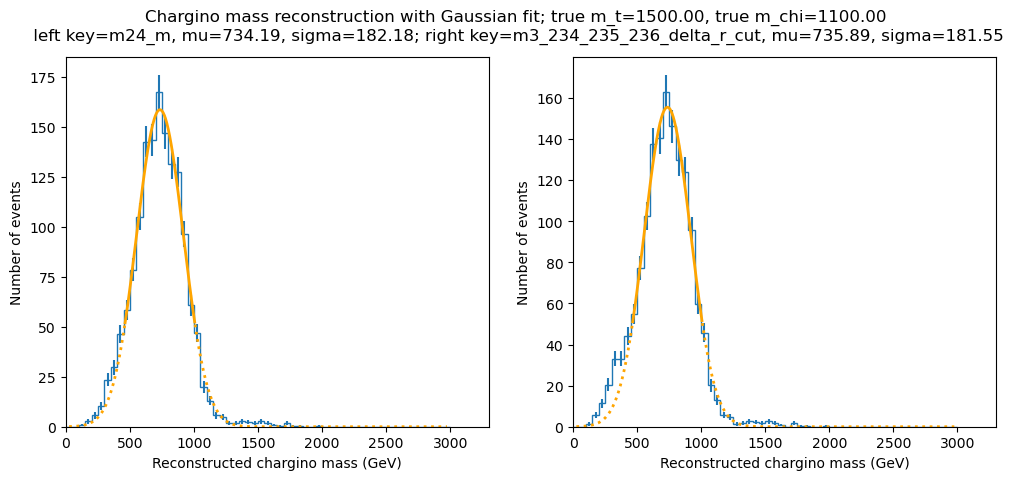

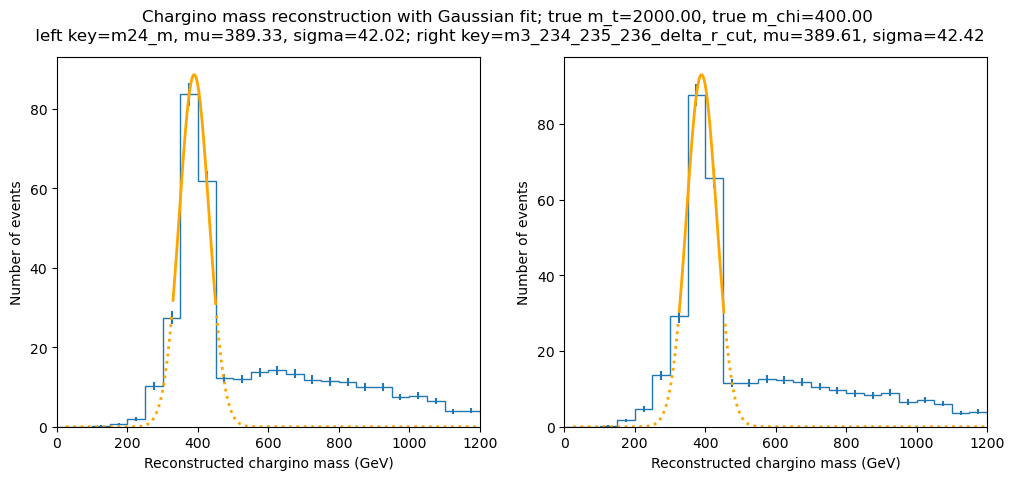

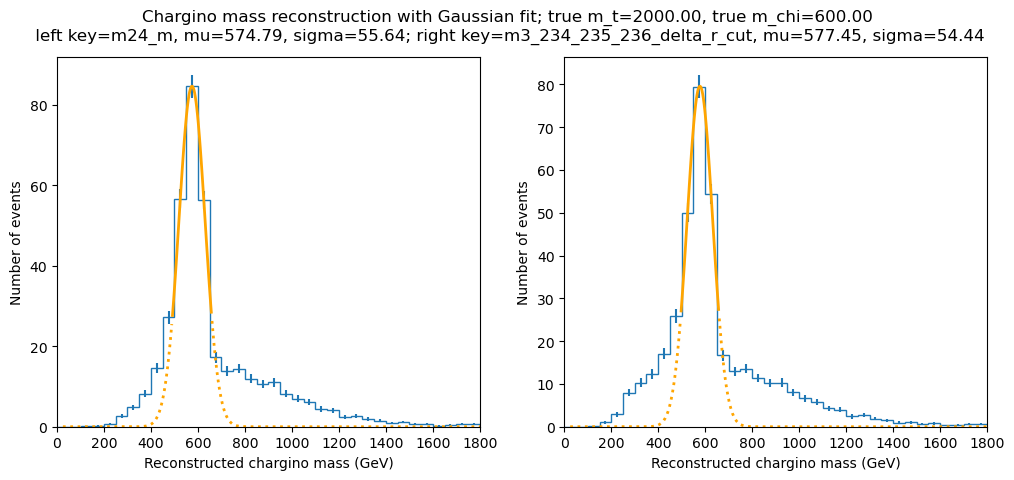

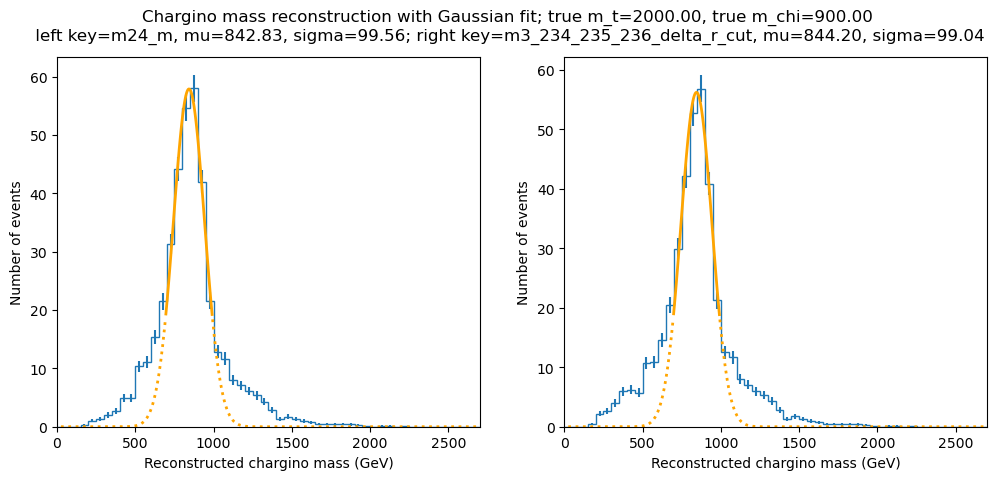

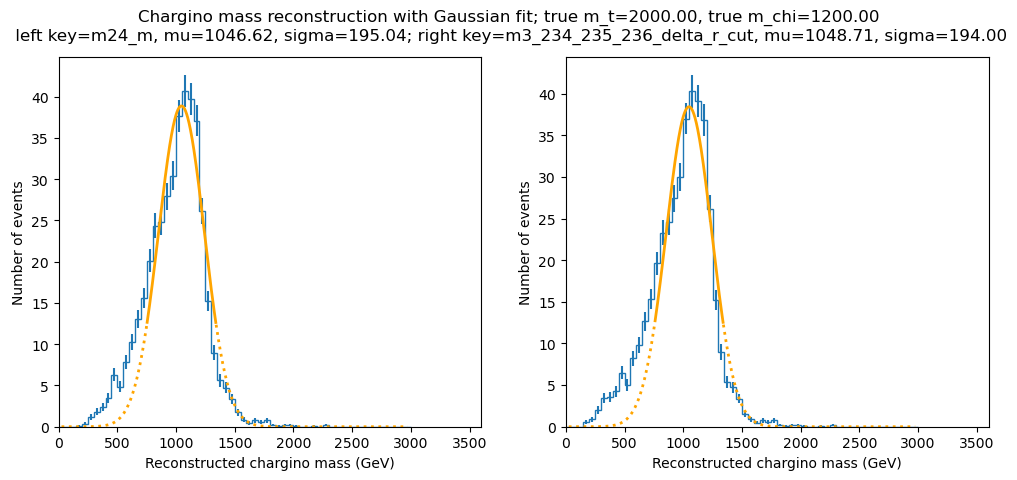

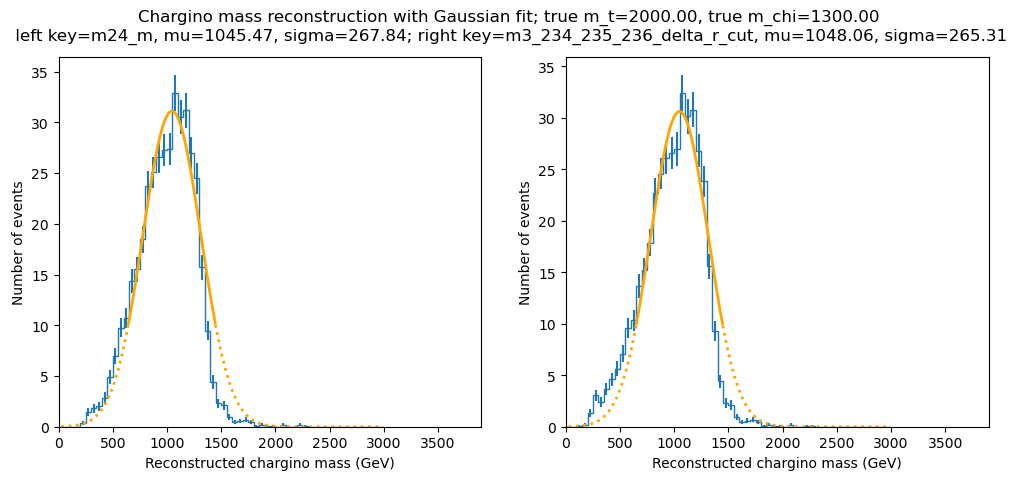

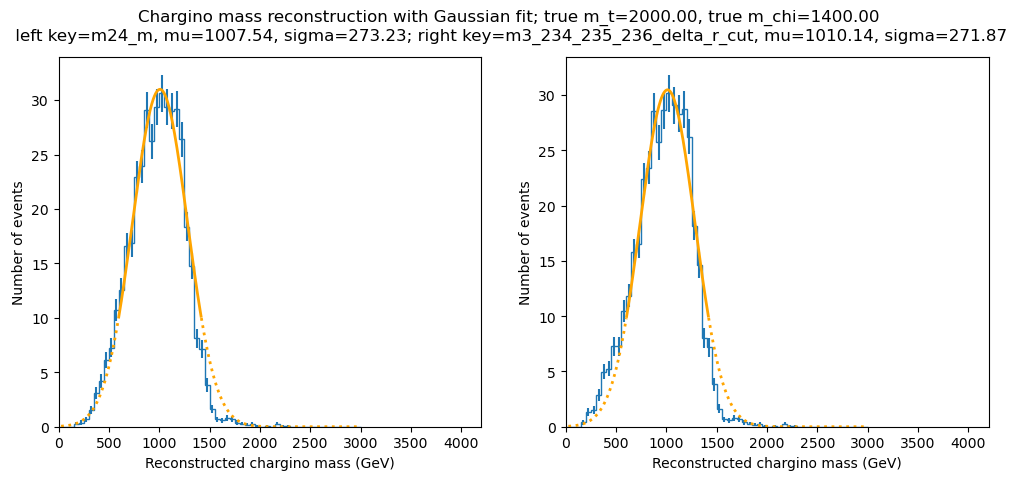

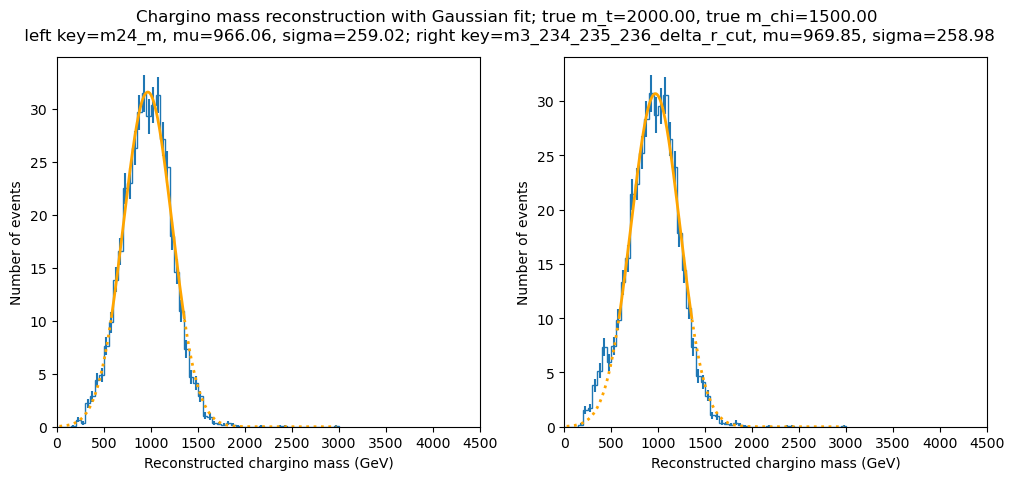

In [33]:
weird_456_comp = gaussian_fit_performance_comparison("m24_m", "m3_234_235_236_delta_r_cut", -0.75, create_plots=True) 

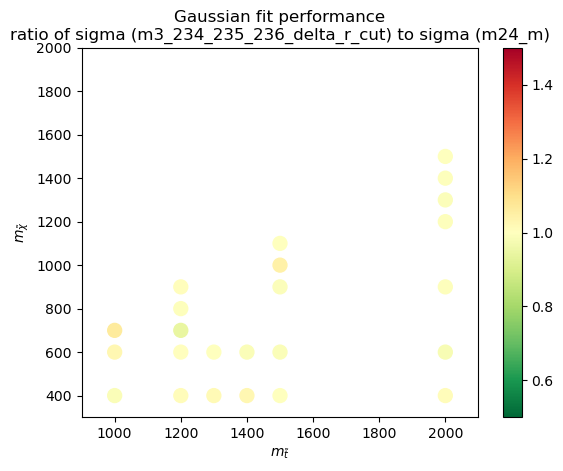

In [34]:
plot_gaussian_perf_comp("m24_m", "m3_234_235_236_delta_r_cut", weird_456_comp)

## Compressed region